# Figure 2: Analysis and ploting

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import utils.CaAnaly as CaaN
import scipy as sp
import scipy.signal as sps
import utils.Plotting as Pl
import sklearn.cluster as sc
from sklearn import metrics
import pandas as pd
import pickle
import utils.Pandas_analysis as PdA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as tukey
import scipy.stats as stats

## Data loading

In [2]:
Save_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Paper_figures/Figure_2/Plots/Final_panels/'

In [ ]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_08_08_df_data'

#import
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)

df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Proportion_resp')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',n,'Resp' + str((n+1)*10) + '%')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',n,'AResp' + str((n+1)*10) + '%')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Whisker_responsive')
df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',-3,'Airpuff_responsive')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']


Number of rows removed: 53


In [621]:
# Make genotype 'WT' 0 ,'het' 1 and 'KO' , 'Control' 2 and 'SSRI' 3
DF_TMP = df.copy()
DF_TMP = DF_TMP.replace('WT',0)
DF_TMP = DF_TMP.replace('HET',1)
DF_TMP = DF_TMP.replace('KO',2)
DF_TMP = DF_TMP.replace('Control',3)
DF_TMP = DF_TMP.replace('SSRI',4)

#Groupby 'animal'
DF_TMP = DF_TMP.groupby('animal').mean()
#Calculate how many animals of each genotype
print('Number of animals of each genotype:')

print('WT: ' + str(len(DF_TMP[DF_TMP['genotype'] == 0])))
print('HET: ' + str(len(DF_TMP[DF_TMP['genotype'] == 1])))
print('KO: ' + str(len(DF_TMP[DF_TMP['genotype'] == 2])))
print('SSRI: ' + str(len(DF_TMP[DF_TMP['genotype'] == 3])))
print('Control: ' + str(len(DF_TMP[DF_TMP['genotype'] == 4])))


Number of animals of each genotype:
WT: 19
HET: 23
KO: 10
SSRI: 12
Control: 12


In [8]:
color1 = '#0cbccc'
color2 = '#107acc'
color3 = '#15297c'
color4= '#b695b0'
color5='#4c007d'



## Event analysis

### Violin plots

In [586]:
# Extract event data
t = 3 # 3 mean 4  82.5 percentile 5 is mean plus one sd
#calculate length og Events and store it in a new coloumn called 'Number_of_events'
for i, row in df.iterrows():
    try:
        df.at[i,'Number_of_events'] = row['Events'][0].shape[0]
        df.at[i,'Recruitment'] = np.nanmean(row['Events'][0][:,t])
        df.at[i,'H_events'] = np.nansum(row['Events'][0][:,t]>=0.8)/20
        df.at[i,'L_events'] = np.nansum((row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2))/20
        df.at[i,'H_L_events'] = np.nansum(row['Events'][0][:,t]>0.2)
        df.at[i,'S_events'] = np.nansum(row['Events'][0][:,t]<0.2)
        df.at[i,'Duration'] = np.nanmean(row['Events'][0][:,2])
        df.at[i,'H_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]>=0.8])
        df.at[i,'L_Duration'] = np.nanmean(row['Events'][0][:,2][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2)])
        df.at[i,'H_L_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]>=0.2])
        df.at[i,'S_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]<0.2])
        df.at[i,'H_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]>=0.8])
        df.at[i,'L_Recruitment'] = np.nanmean(row['Events'][0][:,t][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2)])
        df.at[i,'H_L_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]>=0.2])
        df.at[i,'S_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]<0.2])
        df.at[i,'Event_max'] = np.nanmean(row['Events'][0][:,0])
        df.at[i,'H_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]>=0.8])
        df.at[i,'L_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2)])
        df.at[i,'H_L_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]>=0.2])
        df.at[i,'S_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]<0.2])
        df.at[i,'Late_H_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]>=0.8) & (row['Events'][0][:,1]>=26000)])#[row['Events'][0][:,t]>=0.8]))
        df.at[i,'Late_L_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2) & (row['Events'][0][:,1]>=26000)])#[row['Events'][0][:,t]>=0.8]))
    except:
        pass
    

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/1832578032.py:16: RuntimeWarning: Mean of empty slice
  df.at[i,'S_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]<0.2])
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/1832578032.py:20: RuntimeWarning: Mean of empty slice
  df.at[i,'S_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]<0.2])
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/1832578032.py:25: RuntimeWarning: Mean of empty slice
  df.at[i,'S_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]<0.2])
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/1832578032.py:26: RuntimeWarning: Mean of empty slice
  df.at[i,'Late_H_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]>=0.8) & (row['Events'][0][:,1]>=26000)])#[row['Events'][0][:,t]>=0.8]))
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/1832578032.py:27: RuntimeWarning: Mean of empty slice
  df.at[i,'Late_L_Event_max'] = np.

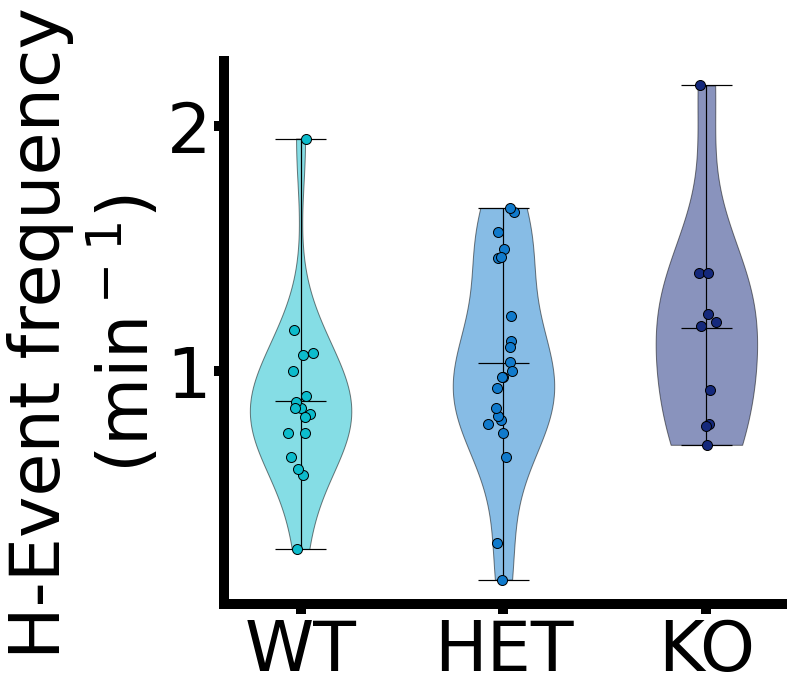

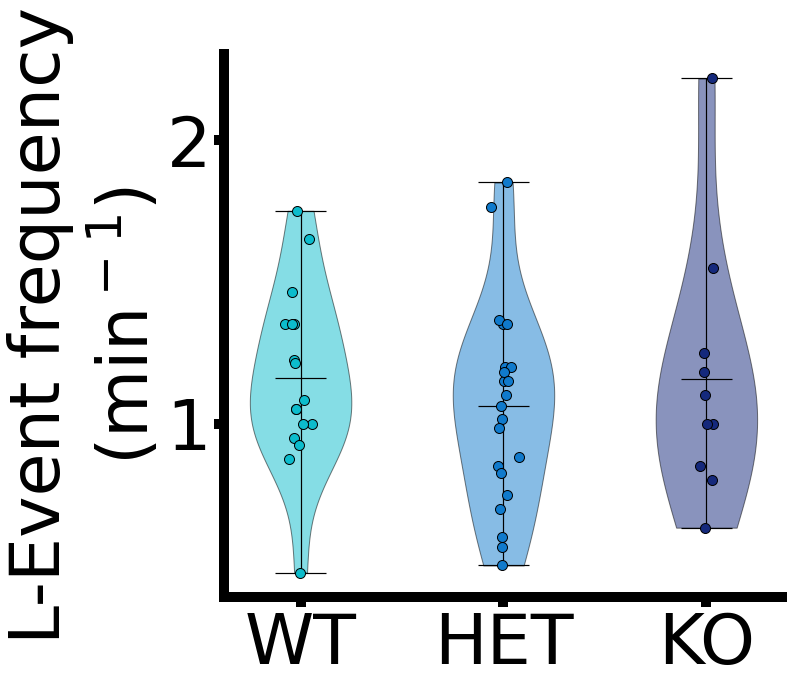

In [587]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_events' , genotypes=['WT','HET','KO'], y_label = 'H-Event frequency\n(min$^-$$^1$)', color = [color1,color2,color3],title = None, fontsize = 70)
plt.savefig(Save_path + 'Blue,H_events_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_events' , genotypes=['WT','HET','KO'], y_label = 'L-Event frequency\n(min$^-$$^1$)', color = [color1,color2,color3],title = None, fontsize = 70)
plt.savefig(Save_path + 'Blue,L_events_violin.svg', dpi=300, bbox_inches='tight')

In [20]:
# Number of H events stats: Both HET and KO are different from WT
CaaN.stating(df[df['age']<11],'H_events',['WT','HET','KO'], alpha=0.05)

Two way ANOVA results:
                         sum_sq     df          F        PR(>F)
C(age)              3270.725979    3.0  15.804595  8.768745e-09
C(genotype)          853.958358    2.0   6.189665  2.728081e-03
C(age):C(genotype)   299.859355    6.0   0.724481  6.306512e-01
Residual            8691.807234  126.0        NaN           NaN
Shapiro p-val:2.6746803996502422e-05


c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Permutation test results:
(0.0, 0.001, 0.643)
Tukey HSD test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   HET     KO   1.9362 0.6421 -3.2849  7.1574  False
   HET     WT  -5.0282 0.0177 -9.3373 -0.7191   True
    KO     WT  -6.9644 0.0075 -12.359 -1.5699   True
----------------------------------------------------


In [34]:
# Number of L events stats: No effect!
CaaN.stating(df[df['age']<11],'L_events',['WT','HET','KO'], alpha=0.05)

Two way ANOVA results:
                       sum_sq     df         F    PR(>F)
C(age)               1.454124    3.0  2.600225  0.055080
C(genotype)          0.990467    2.0  2.656690  0.074110
C(age):C(genotype)   0.263004    6.0  0.235149  0.964308
Residual            23.487658  126.0       NaN       NaN
Shapiro p-val:0.07633484154939651


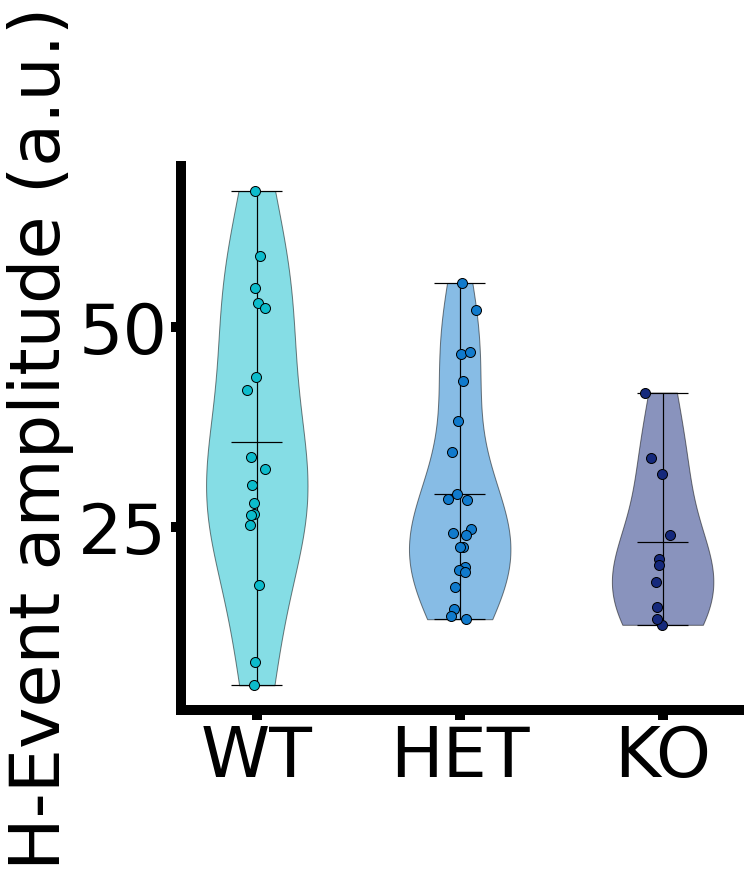

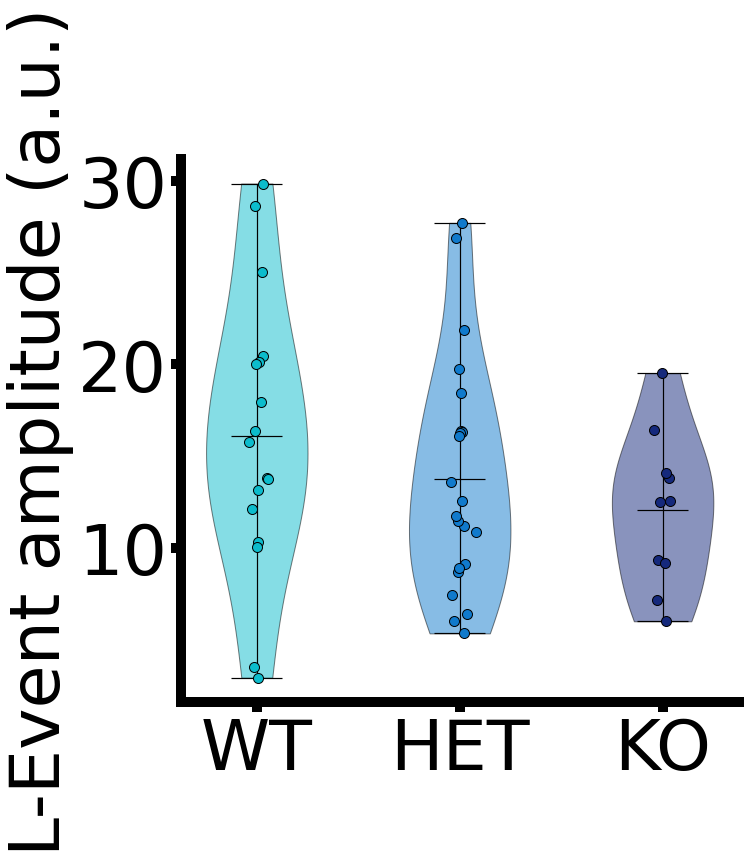

In [588]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_Event_max' , genotypes=['WT','HET','KO'], y_label = 'H-Event amplitude (a.u.)', color = [color1,color2,color3],title = None, fontsize = 70)
plt.savefig(Save_path + 'H_event_max_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_Event_max' , genotypes=['WT','HET','KO'], y_label = 'L-Event amplitude (a.u.)', color = [color1,color2,color3],title = None, fontsize = 70)
plt.savefig(Save_path + 'L_event_max_violin.svg', dpi=300, bbox_inches='tight')

In [65]:
# H event amplitude: Both HET and KO are different from WT
CaaN.stating(df[df['age']<11],'H_Event_max',['WT','HET','KO'], alpha=0.05, Fisher=False)

Two way ANOVA results:
                          sum_sq     df          F    PR(>F)
C(age)              10414.799505    3.0  11.178544  0.000001
C(genotype)          3078.139217    2.0   4.955801  0.008476
C(age):C(genotype)    562.602622    6.0   0.301930  0.934898
Residual            39130.460877  126.0        NaN       NaN
Shapiro p-val:5.787935819512313e-08
Permutation test results:
(0.0, 0.003, 0.939)
Tukey HSD test results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   HET     KO  -4.2123 0.6038 -14.7667  6.3421  False
   HET     WT   9.2967 0.0334    0.586 18.0073   True
    KO     WT   13.509 0.0108   2.6042 24.4138   True
-----------------------------------------------------


In [25]:
# L event amplitude: No effect on the anova, although p_val 0.06
CaaN.stating(df[df['age']<11],'L_Event_max',['WT','HET','KO'], alpha=0.05)

Two way ANOVA results:
                         sum_sq     df         F    PR(>F)
C(age)              1114.432345    3.0  6.140583  0.000625
C(genotype)          336.033050    2.0  2.777340  0.066016
C(age):C(genotype)   121.091290    6.0  0.333610  0.918106
Residual            7622.429650  126.0       NaN       NaN
Shapiro p-val:7.151558747864328e-06


c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Permutation test results:
(0.0, 0.062, 0.906)


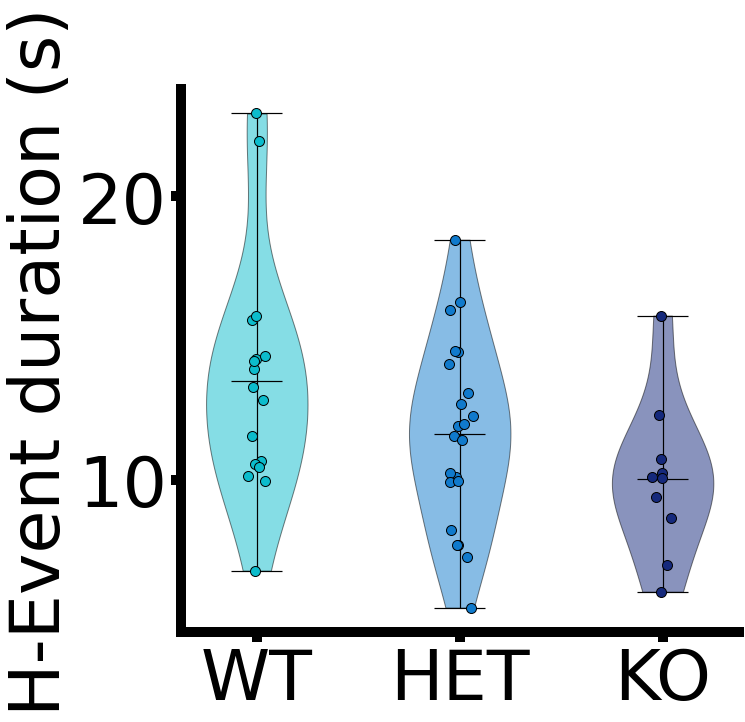

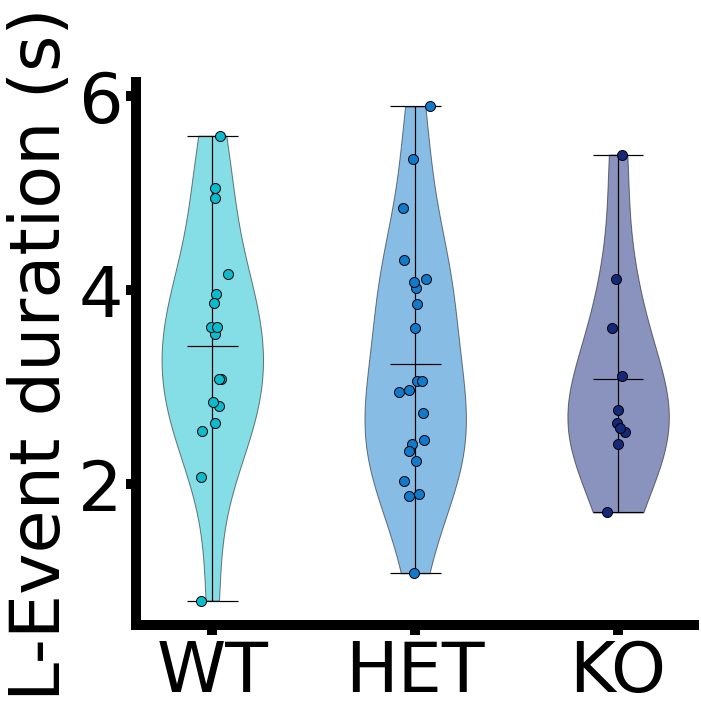

In [589]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_Duration' , genotypes=['WT','HET','KO'], y_label = 'H-Event duration (s)', color = [color1,color2,color3],title = None, fontsize = 70)
plt.savefig(Save_path + 'H_event_duration_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_Duration' , genotypes=['WT','HET','KO'], y_label = 'L-Event duration (s)', color = [color1,color2,color3],title = None, fontsize = 70)
plt.savefig(Save_path + 'L_event_duration_violin.svg', dpi=300, bbox_inches='tight')

In [43]:
# H event duration: KO Aand WT are different, HET p-val 0.054, it is significant with Fisher LSD's
CaaN.stating(df[df['age']<11],'H_Duration',['WT','HET','KO'], alpha=0.05, Fisher = False)
CaaN.stating(df[df['age']<11],'H_Duration',['WT','HET','KO'], alpha=0.05, Fisher = True)

Two way ANOVA results:
                         sum_sq     df         F    PR(>F)
C(age)                63.136254    3.0  0.617602  0.604851
C(genotype)          316.552597    2.0  4.644803  0.011316
C(age):C(genotype)   109.575158    6.0  0.535935  0.780085
Residual            4293.575534  126.0       NaN       NaN
Shapiro p-val:5.037066709304909e-16


c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does 

Permutation test results:
(0.649, 0.007, 0.768)
Tukey HSD test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   HET     KO  -1.4631 0.5155 -4.6141  1.688  False
   HET     WT   2.5622 0.0545 -0.0384 5.1628  False
    KO     WT   4.0253  0.011  0.7696 7.2809   True
---------------------------------------------------
Two way ANOVA results:
                         sum_sq     df         F    PR(>F)
C(age)                63.136254    3.0  0.617602  0.604851
C(genotype)          316.552597    2.0  4.644803  0.011316
C(age):C(genotype)   109.575158    6.0  0.535935  0.780085
Residual            4293.575534  126.0       NaN       NaN
Shapiro p-val:5.037066709304909e-16


c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Permutation test results:
(0.634, 0.005, 0.756)
Fisher LSD test results:
[{'group1': 'WT', 'group2': 'HET', 'mean_diff': 2.562167029902641, 't_stat': 2.0275491593348898, 'ci_lower': 0.05760050285255325, 'ci_upper': 5.0667335569527285, 'significant': True, 'pval': 0.045045970433046374}]
[{'group1': 'WT', 'group2': 'HET', 'mean_diff': 2.562167029902641, 't_stat': 2.0275491593348898, 'ci_lower': 0.05760050285255325, 'ci_upper': 5.0667335569527285, 'significant': True, 'pval': 0.045045970433046374}, {'group1': 'WT', 'group2': 'KO', 'mean_diff': 4.0252566064516255, 't_stat': 3.0230219152258857, 'ci_lower': 1.3727047627222793, 'ci_upper': 6.677808450180972, 'significant': True, 'pval': 0.0034238429558435513}]
[{'group1': 'WT', 'group2': 'HET', 'mean_diff': 2.562167029902641, 't_stat': 2.0275491593348898, 'ci_lower': 0.05760050285255325, 'ci_upper': 5.0667335569527285, 'significant': True, 'pval': 0.045045970433046374}, {'group1': 'WT', 'group2': 'KO', 'mean_diff': 4.0252566064516255, 't_stat

In [37]:
# L event duration: No difference, anova p_val 0.57
CaaN.stating(df[df['age']<11],'L_Duration',['WT','HET','KO'], alpha=0.05)

Two way ANOVA results:
                        sum_sq     df         F    PR(>F)
C(age)                0.402257    3.0  0.073280  0.974211
C(genotype)           2.051416    2.0  0.560570  0.572301
C(age):C(genotype)    2.397320    6.0  0.218364  0.970319
Residual            230.549841  126.0       NaN       NaN
Shapiro p-val:0.0017766571836546063
Permutation test results:
(0.973, 0.563, 0.968)


### Event heatmaps

In [185]:
Order = ['WT','HET','KO','Control','SSRI']
Animals = ['301','327','225','419','449']
Dates = ['2023-01-28','2023-03-13','2022-08-14','2023-06-02','2023-07-18']
rows = [205,251,74,473,544]
PeriHs = []
for i in range(0,len(Animals)):
    date = Dates[i]
    animal = Animals[i]
    row = rows[i]
    path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Data/'+ date + '/' + date + '_GOS' + animal + '_t-001/suite2p/plane0/'
    tmp = CaaN.Peri_H_event(path,df,row)
    PeriHs.append(tmp)
#'//qnap-amp001.dpag.ox.ac.uk/gsantero/Data/'+ date + '/' + date + '_GOS' + animal + '_t-001/suite2p/plane0/'
#CaaN.Peri_H_event(path,df,row)


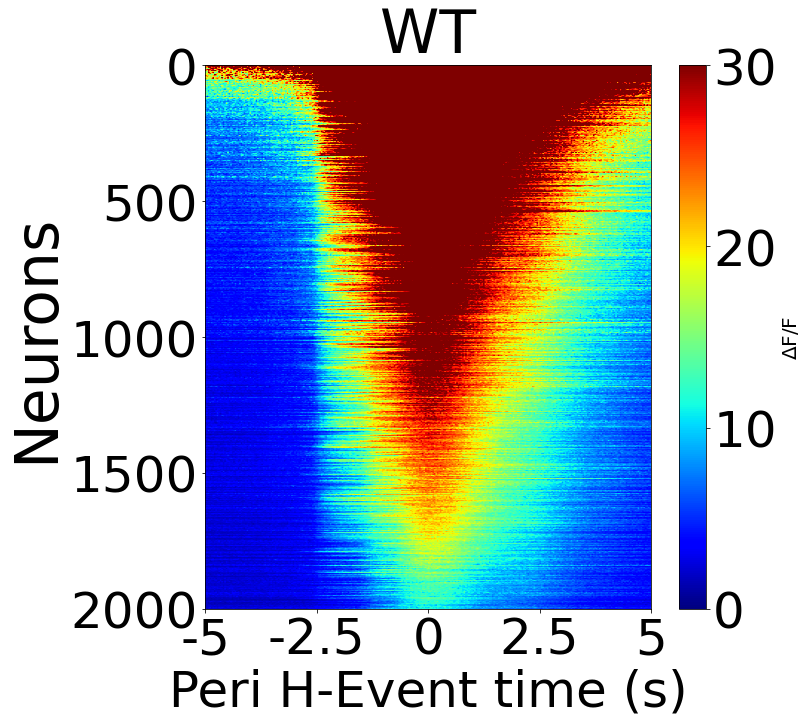

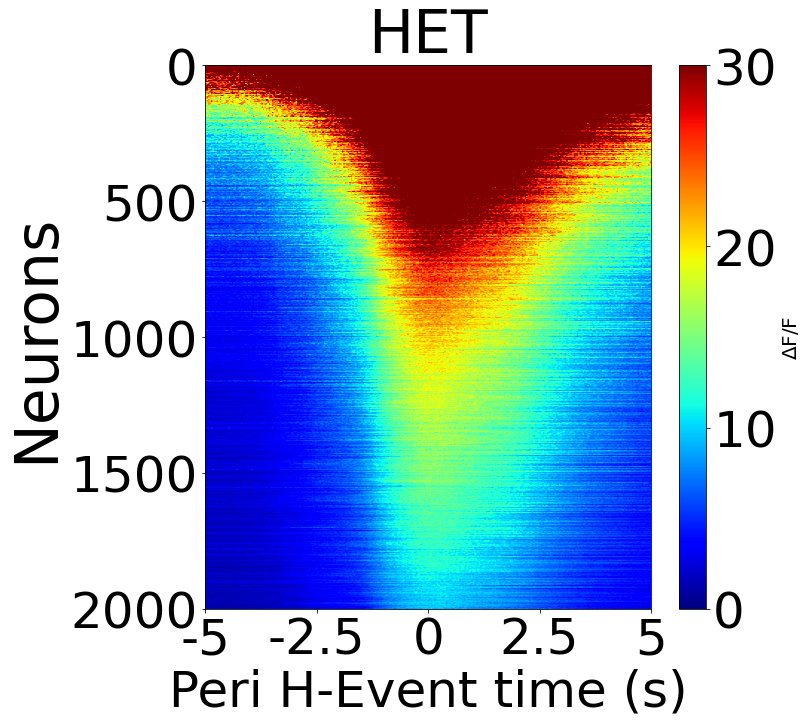

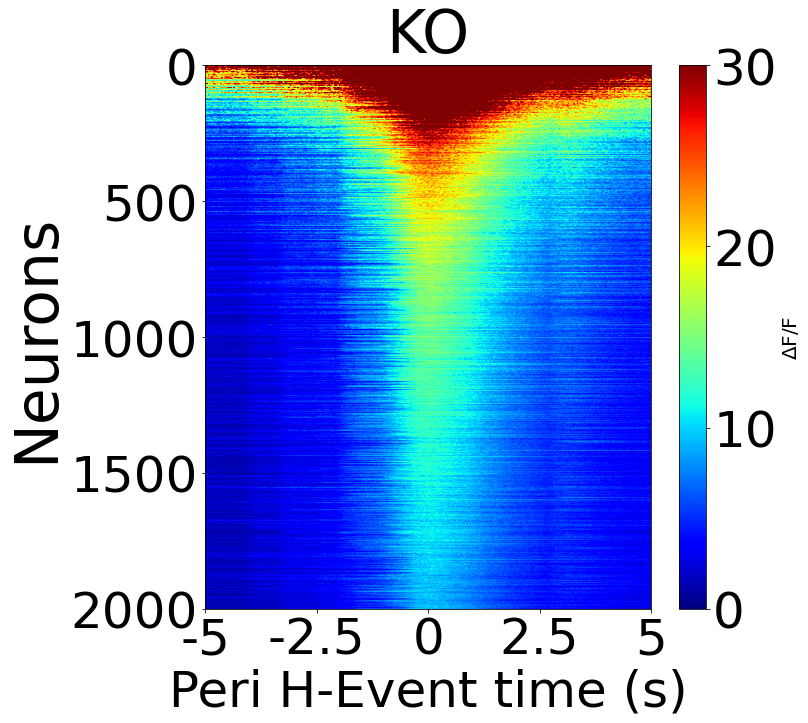

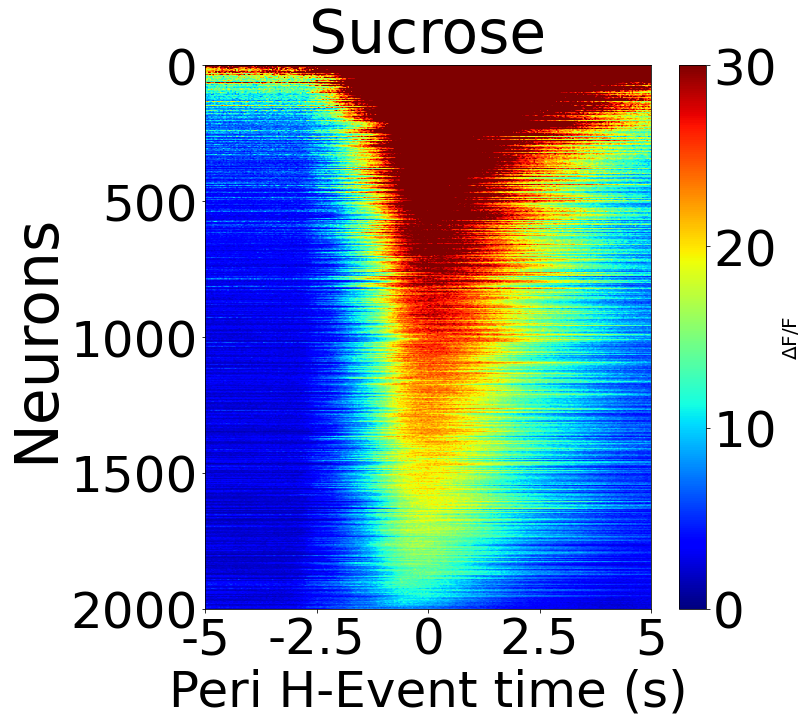

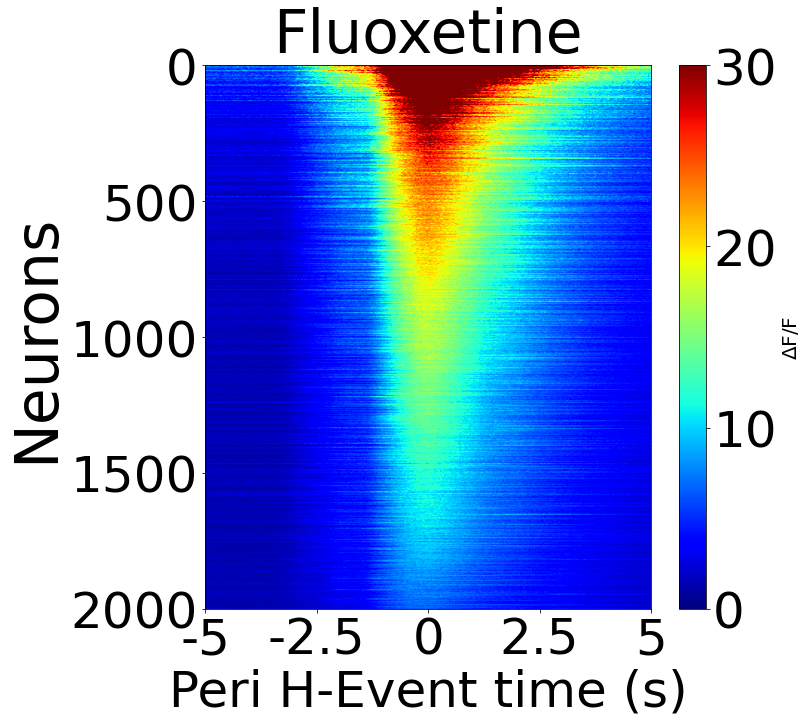

In [216]:
labels = ['WT','HET','KO','Sucrose','Fluoxetine']
for i in range(0,len(PeriHs)):
    peri = PeriHs[i]
    plt.figure(figsize=(10,10))
    Pl.Plot_periH_heat_map(peri,num_cells=2000,vmin=0,vmax=30)
    #Label colorbar as ΔF/F
    cm = plt.colorbar(label='$\Delta$F/F')
    #cm.ax.tick_params(labelsize=100)
    #Save figure
    plt.title(labels[i],fontsize=60)
    #plt.savefig(Save_path + 'PeriH_' + labels[i] + '.svg', dpi=300, bbox_inches='tight',format='svg')


    #Label

## Whisker responses

In [34]:
print(len(df[df['age']>=21]))
df_t = df.copy()
df_t['age'] = df_t['age'].apply(lambda x: 21 if x >= 20 else x)
print(len(df_t[df_t['age']==21]))
#How many rows of each genotype at age 21
print('Number of animals of each genotype at age 21:')
print('WT: ' + str(len(df_t[(df_t['genotype'] == 'WT') & (df_t['age'] == 21)])))
print('HET: ' + str(len(df_t[(df_t['genotype'] == 'HET') & (df_t['age'] == 21)])))
print('KO: ' + str(len(df_t[(df_t['genotype'] == 'KO') & (df_t['age'] == 21)])))
print('Control: ' + str(len(df_t[(df_t['genotype'] == 'Control') & (df_t['age'] == 21)])))
print('SSRI: ' + str(len(df_t[(df_t['genotype'] == 'SSRI') & (df_t['age'] == 21)])))


32
32
Number of animals of each genotype at age 21:
WT: 4
HET: 5
KO: 3
Control: 11
SSRI: 9


(-0.5, 9.5)

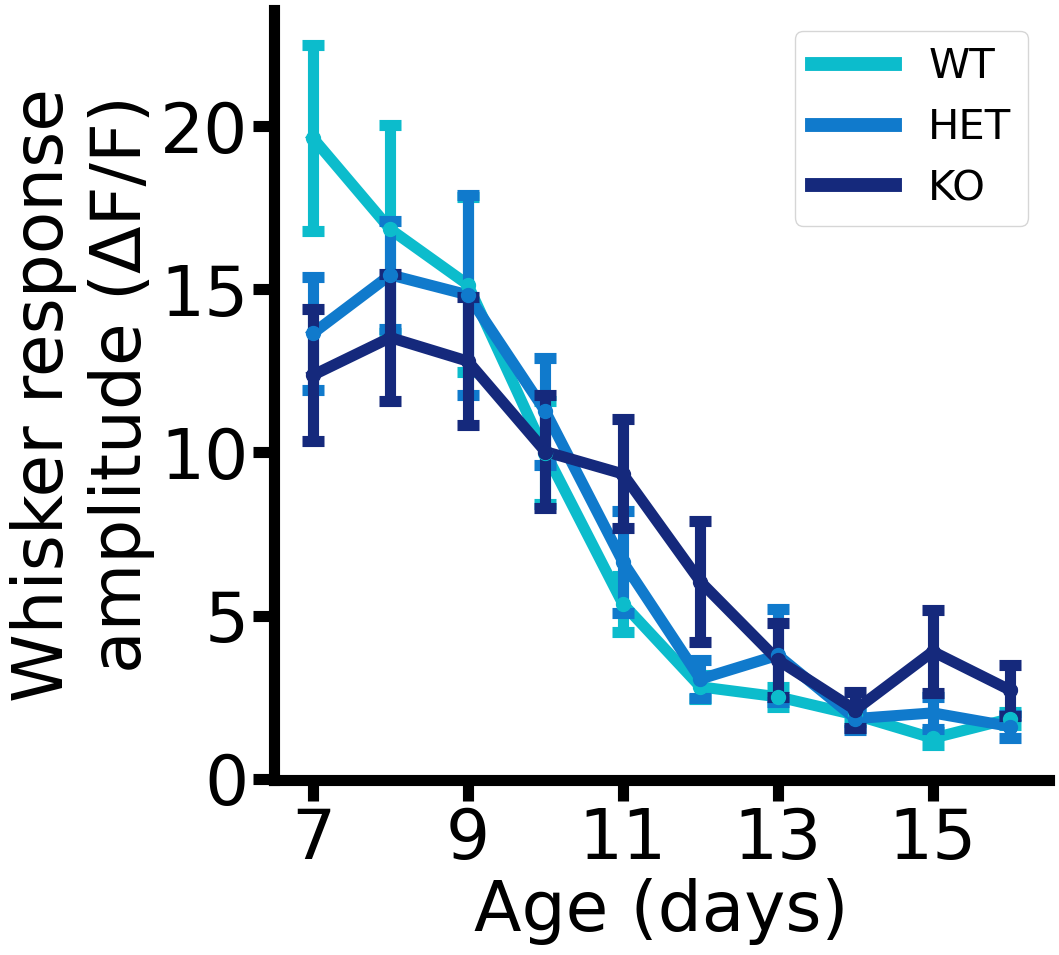

In [19]:

#Calculate AUC in the cropped traces and store it in a new column called 'Whisker_response_AUC_cropped'
df['Whisker_response_trace_cropped'] = None
df['Whisker_response_max_cropped'] = np.nan
for i, row in df.iterrows():

  if row['Whisker_responsive']>=0.0:
    try:
      tmp =  row['Whisker_response_trace'][:660]
      df.at[i,'Whisker_response_trace_cropped'] = tmp
      #if it is nan or none, remove it
      df.at[i,'Whisker_response_max_cropped'] = np.max(tmp[60:])
    except:
      df.at[i,'Whisker_response_max_cropped'] = np.nan
  else:
    df.at[i,'Whisker_response_max_cropped'] = np.nan

#Plot as a function of age
plt.figure(figsize=(10,10))
PdA.developmental_plot_errorbars(df[df['age']<17],'Whisker_response_max_cropped', y_label='Whisker response\n amplitude (ΔF/F)',genotype=['WT','HET','KO'],color=[color1,color2,color3],fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlim([-0.5, 9.5])

#plt.savefig(Save_path + 'Blue_Whisker_response_amplitude.svg',bbox_inches='tight',dpi=300)

c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:648: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(globals()[g][:,:60],axis=1)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:657: RuntimeWarning: Mean of empty slice
  globals()[g] = stat(globals()[g][:,60:],axis=1)


Kruskal Wallis test: KruskalResult(statistic=3.697373737373738, pvalue=0.15744377498277037)
Tukey: Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0   0.1788 0.4187 -0.1621 0.5198  False
   1.0    3.0   0.3646  0.101 -0.0563 0.7854  False
   2.0    3.0   0.1857 0.5042 -0.2149 0.5864  False
---------------------------------------------------


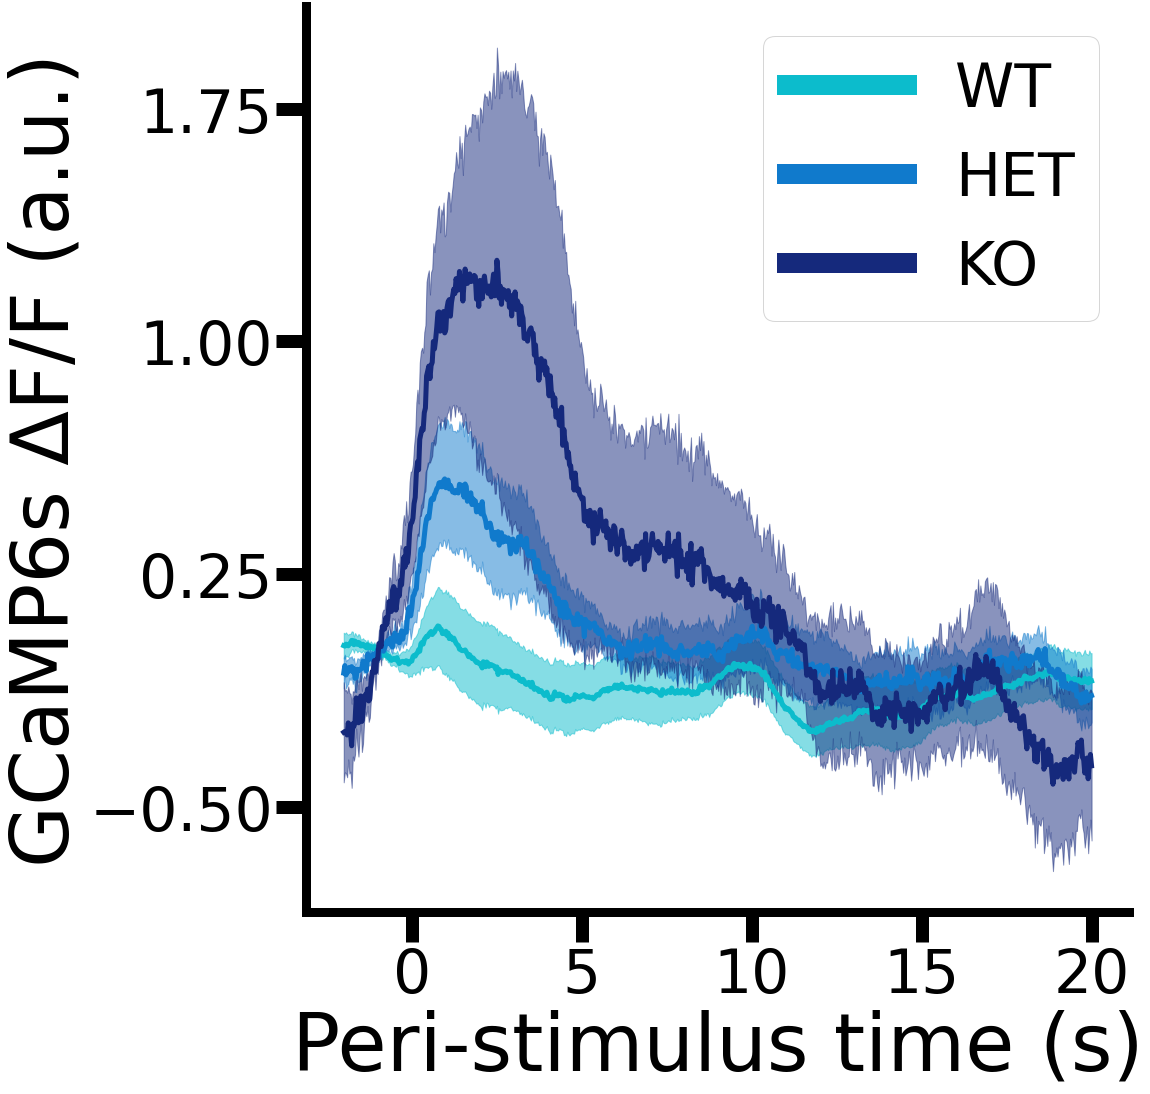

In [599]:
#P11-13
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():
    #if row['Whisker_responsive']>=0.0:
    #if row['Whisker_responsive']>=0.01: 
        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Whisker_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['WT','HET','KO'], ages=[11,12,13], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)
leg = plt.legend(fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Peri-stimulus time (s)',fontsize=80)
plt.xticks(np.linspace(0,600,5),np.linspace(0,20,5).astype(int),fontsize=60)
plt.yticks(np.arange(-0.5,2,0.75), fontsize=60)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Blue_Whisker_response_22s_p11-13.svg',dpi=300)


c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:682: RuntimeWarning: Mean of empty slice
  print('ANOVA: ' + str(scipy.stats.f_oneway(globals()[genotypes[0]],globals()[genotypes[1]],globals()[genotypes[2]])))
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:682: RuntimeWarning: Mean of empty slice
  print('ANOVA: ' + str(scipy.stats.f_oneway(globals()[genotypes[0]],globals()[genotypes[1]],globals()[genotypes[2]])))
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:682: RuntimeWarning: Mean of empty slice
  print('ANOVA: ' + str(scipy.stats.f_oneway(globals()[genotypes[0]],globals()[genotypes[1]],globals()[genotypes[2]])))
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:691: RuntimeWarning: Mean of empty slice
  if vertical_line == True:


ANOVA: F_onewayResult(statistic=3.666083454591322, pvalue=0.04745469026664498)
Tukey: Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0   0.3425  0.198 -0.1444 0.8293  False
   1.0    3.0   0.5608 0.0377  0.0296  1.092   True
   2.0    3.0   0.2183 0.4064 -0.2067 0.6433  False
---------------------------------------------------


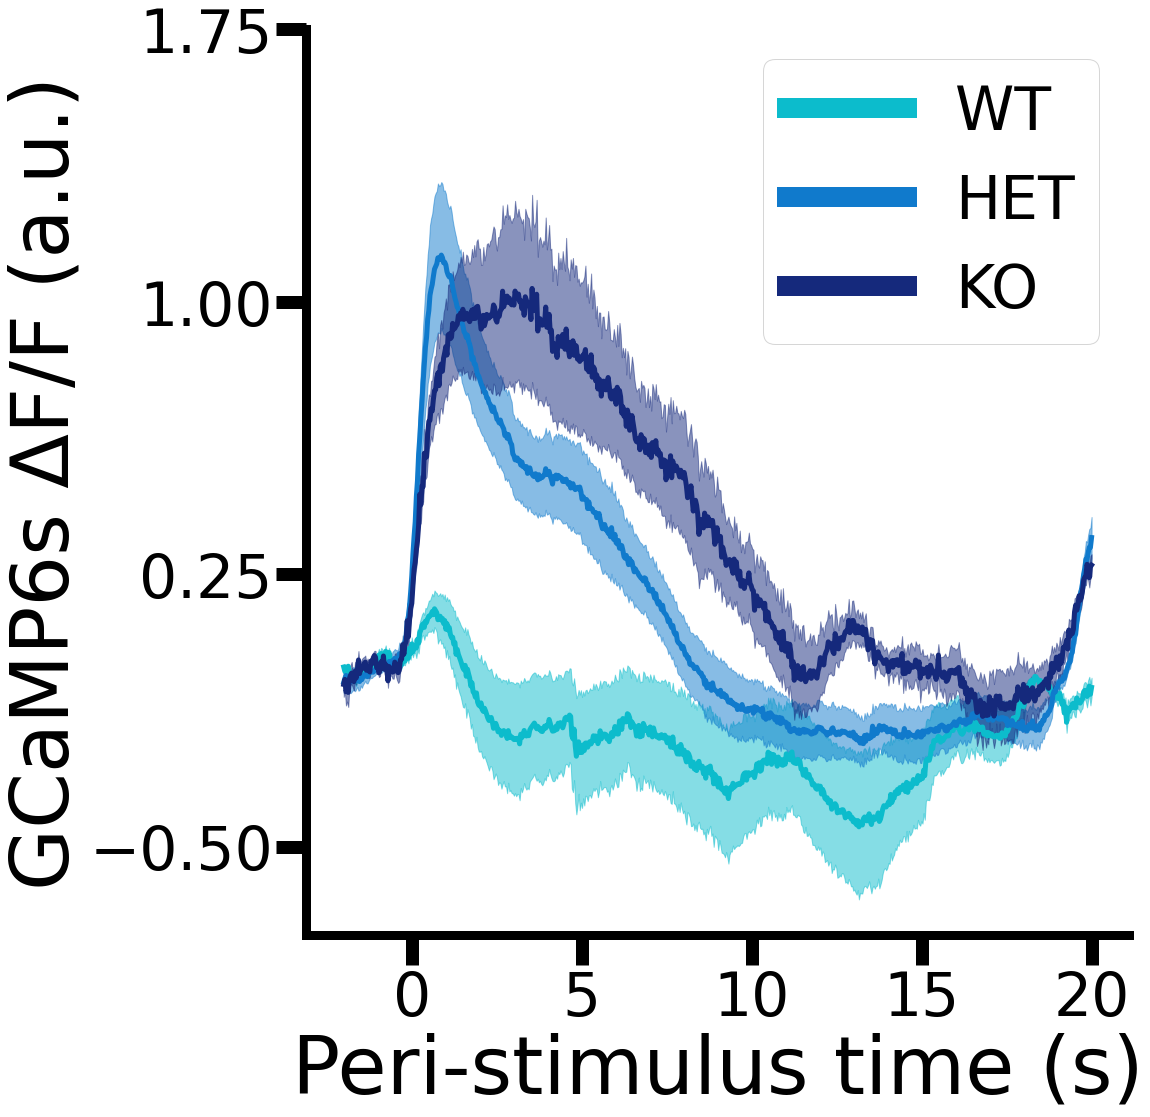

In [612]:
#Airpuff P11-13
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():
    #if row['Whisker_responsive']>=0.0:
    #if row['Whisker_responsive']>=0.01: 
        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Airpuff_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['WT','HET','KO'], ages=[11,12,13], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)
leg = plt.legend(fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Peri-stimulus time (s)',fontsize=80)
plt.xticks(np.linspace(0,600,5),np.linspace(0,20,5).astype(int),fontsize=60)
plt.yticks(np.arange(-0.5,2,0.75), fontsize=60)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Blue_Airpuff_response_22s_p11-13.svg',dpi=300)


c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:682: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(globals()[g][:,:60],axis=1)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:691: RuntimeWarning: Mean of empty slice
  globals()[g] = stat(globals()[g][:,60:],axis=1)


ANOVA: F_onewayResult(statistic=0.4111634510340722, pvalue=0.6696861474693332)
Tukey: Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0    0.254 0.7736 -0.6984 1.2065  False
   1.0    3.0   0.3739 0.6459  -0.694 1.4419  False
   2.0    3.0   0.1199 0.9191 -0.6688 0.9086  False
---------------------------------------------------


C:\Users\gabrielos\AppData\Local\Temp\ipykernel_199172\1893072457.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for leg in leg.legendHandles:


Text(-33.08333333333333, 0.5, 'GCaMP6s ΔF/F (a.u.)')

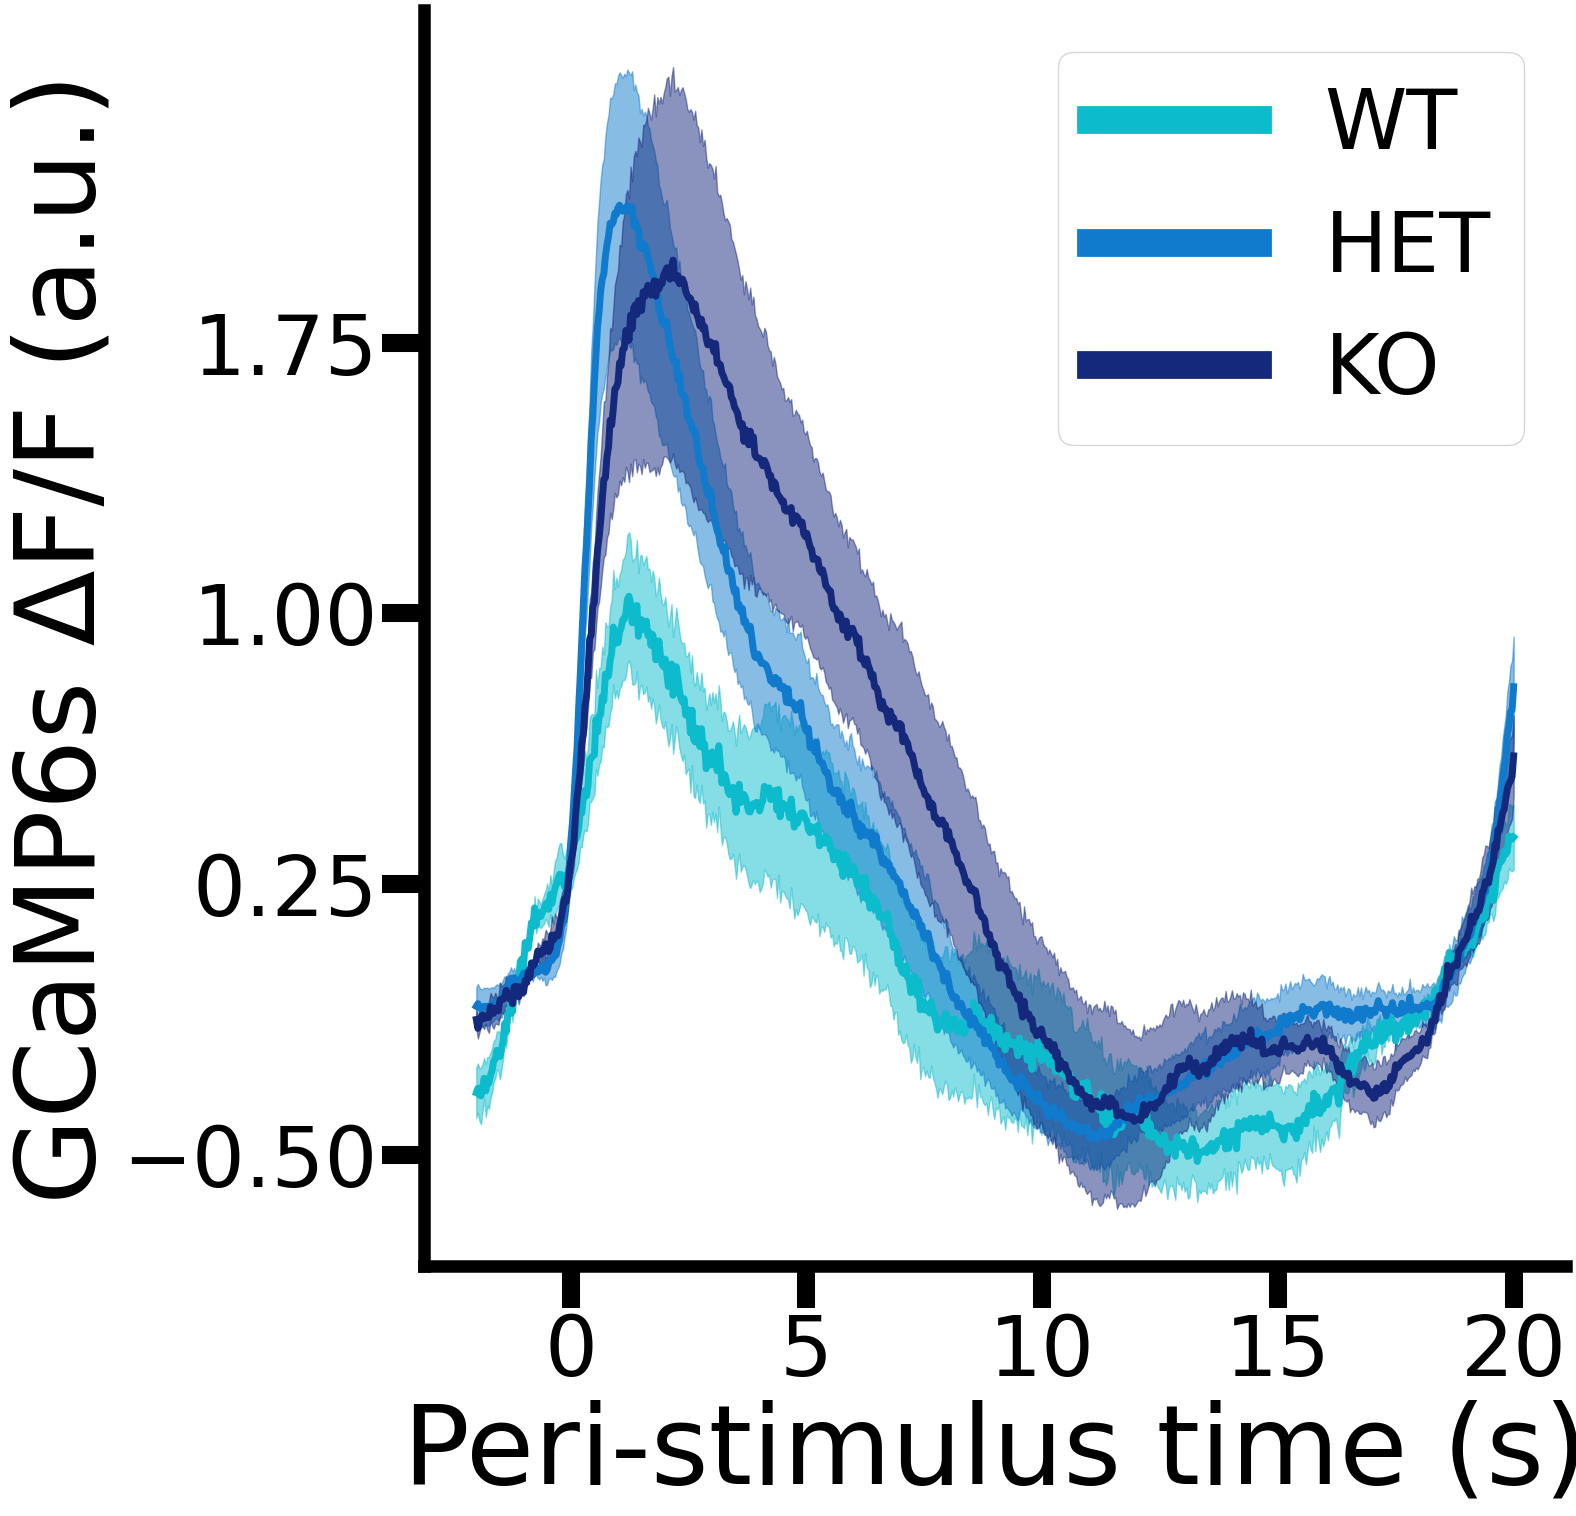

In [28]:
#Airpuff P11-13
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():
    #if row['Whisker_responsive']>=0.0:
    #if row['Whisker_responsive']>=0.01: 
        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Airpuff_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['WT','HET','KO'], ages=[7,8,9,10], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1)
leg = plt.legend(fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Peri-stimulus time (s)',fontsize=80)
plt.xticks(np.linspace(0,600,5),np.linspace(0,20,5).astype(int),fontsize=60)
plt.yticks(np.arange(-0.5,2,0.75), fontsize=60)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
#plt.savefig(Save_path + 'Blue_Airpuff_response_22s_p11-13.svg',dpi=300)


ANOVA: F_onewayResult(statistic=0.5362127253003192, pvalue=0.5995009022960085)
Tukey: Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0    0.032 0.9455 -0.2385 0.3026  False
   1.0    3.0   0.0995 0.6476 -0.1969 0.3958  False
   2.0    3.0   0.0674 0.6699 -0.1421  0.277  False
---------------------------------------------------


c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:682: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(globals()[g][:,:60],axis=1)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:691: RuntimeWarning: Mean of empty slice
  globals()[g] = stat(globals()[g][:,60:],axis=1)
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_199172\1810172846.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for leg in leg.legendHandles:


Text(-33.08333333333333, 0.5, 'GCaMP6s ΔF/F (a.u.)')

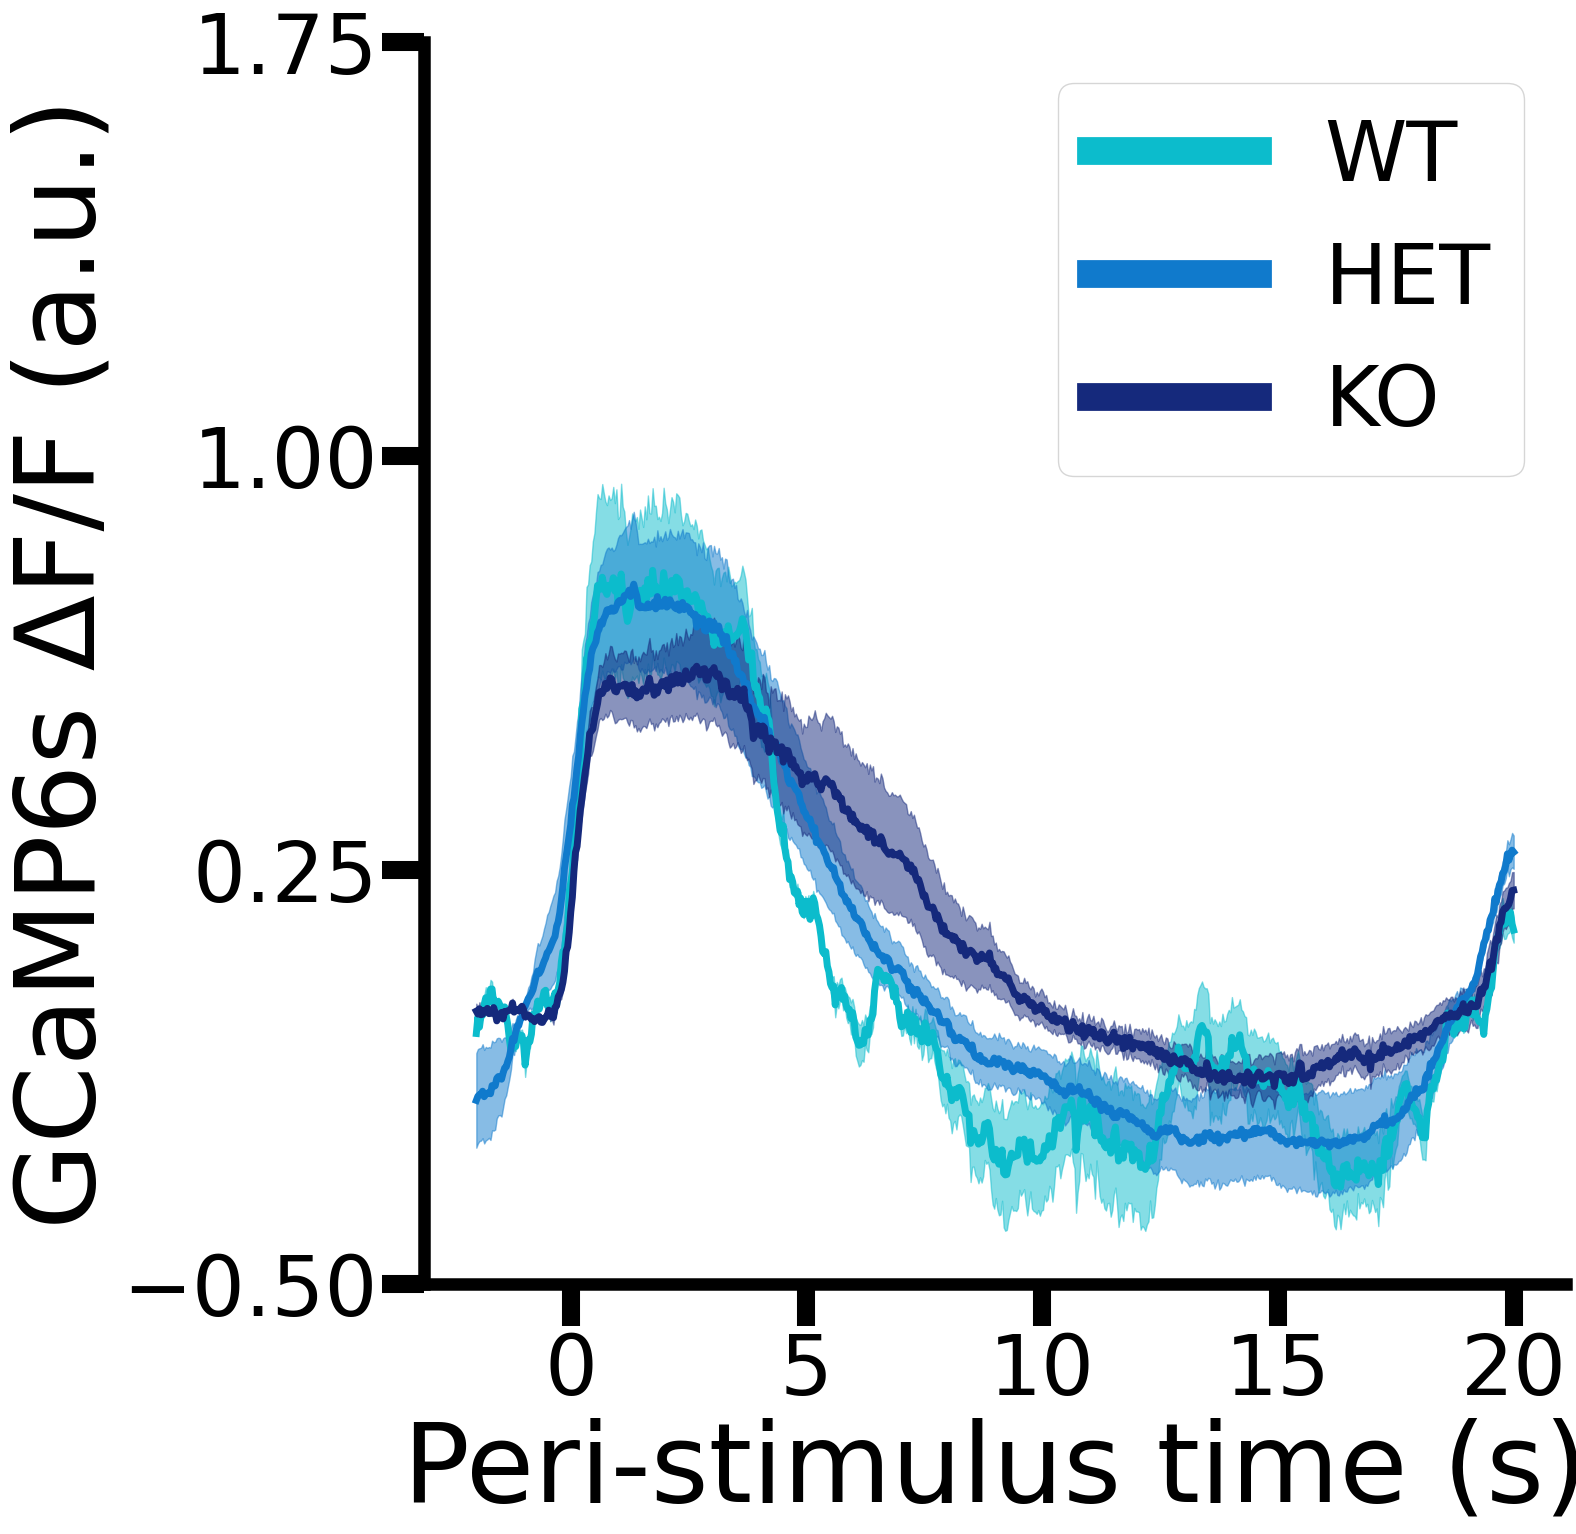

In [29]:
#Airpuff P11-13
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():
    #if row['Whisker_responsive']>=0.0:
    #if row['Whisker_responsive']>=0.01: 
        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Airpuff_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['WT','HET','KO'], ages=[14,15,16], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1)
leg = plt.legend(fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Peri-stimulus time (s)',fontsize=80)
plt.xticks(np.linspace(0,600,5),np.linspace(0,20,5).astype(int),fontsize=60)
plt.yticks(np.arange(-0.5,2,0.75), fontsize=60)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
#plt.savefig(Save_path + 'Blue_Airpuff_response_22s_p11-13.svg',dpi=300)


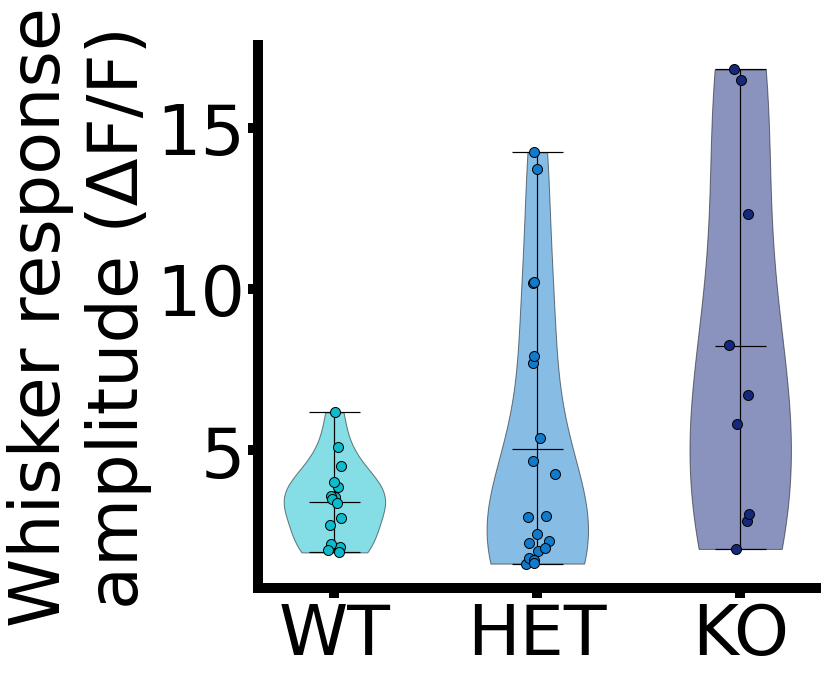

In [600]:
plt.figure(figsize=(10,10))
df_2 = df[df['Whisker_response_max_cropped'].notnull()]
PdA.violin_plot(df_2[(df_2['age']>10)&(df_2['age']<14)],parameter='Whisker_response_max_cropped' , genotypes=['WT','HET','KO'], y_label = 'Whisker response\namplitude (ΔF/F)', color = [color1,color2,color3],title = None, fontsize = 70)
#Savefig
plt.savefig(Save_path + 'P11-13Whisker_response_max_violin.svg', dpi=300, bbox_inches='tight',format='svg')

In [306]:
# Testing significance WT KO different
df_WT_HET_KO = df[(df['genotype']=='WT') | (df['genotype']=='HET') | (df['genotype']=='KO')]
#Replace control for 0 and ssri for     

#select age <11
df_WT_HET_KO = df_WT_HET_KO[(df_WT_HET_KO['age']>10) & (df_WT_HET_KO['age']<14)]
#df_WT_HET_KO = df_WT_HET_KO.groupby(['animal']).mean()

df_WT_HET_KO = df_WT_HET_KO.replace('WT',0)
df_WT_HET_KO = df_WT_HET_KO.replace('HET',1)
df_WT_HET_KO = df_WT_HET_KO.replace('KO',2)
#Remove nans in whisker response max
df_WT_HET_KO = df_WT_HET_KO[df_WT_HET_KO['Whisker_response_max_cropped'].notnull()]
# Import f one way
from scipy.stats import f_oneway
# Perform the ANOVA
print(f_oneway(df_WT_HET_KO[df_WT_HET_KO['genotype']==0]['Whisker_response_max_cropped'],df_WT_HET_KO[df_WT_HET_KO['genotype']==1]['Whisker_response_max_cropped'],df_WT_HET_KO[df_WT_HET_KO['genotype']==2]['Whisker_response_max_cropped']))

# Fisher LSD
CaaN.fishers_lsd_from_df(df_WT_HET_KO, 'Whisker_response_max_cropped', 'genotype', alpha=0.05)


c:\Users\gabrielos\anaconda3\lib\site-packages\pandas\core\missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


F_onewayResult(statistic=3.3199236468477324, pvalue=0.03998788443581266)


[{'group1': 0,
  'group2': 1,
  'mean_diff': -0.9752592814666152,
  't_stat': -1.1691470268453172,
  'ci_lower': -2.63437609171954,
  'ci_upper': 0.6838575287863093,
  'significant': False,
  'pval': 0.24569115189038032},
 {'group1': 0,
  'group2': 2,
  'mean_diff': -3.0353597905470298,
  't_stat': -2.658740690204353,
  'ci_lower': -5.321480868744803,
  'ci_upper': -0.7492387123492561,
  'significant': True,
  'pval': 0.010162884230129489}]

c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:648: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(globals()[g][:,:60],axis=1)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:648: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(globals()[g][:,:60],axis=1)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:657: RuntimeWarning: Mean of empty slice
  globals()[g] = stat(globals()[g][:,60:],axis=1)


Kruskal Wallis test: KruskalResult(statistic=1.5398656898656924, pvalue=0.463044163028996)
Tukey: Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0  -0.0202    0.9 -0.1528 0.1125  False
   1.0    3.0  -0.0387 0.7996 -0.1936 0.1162  False
   2.0    3.0  -0.0185    0.9 -0.1696 0.1326  False
---------------------------------------------------


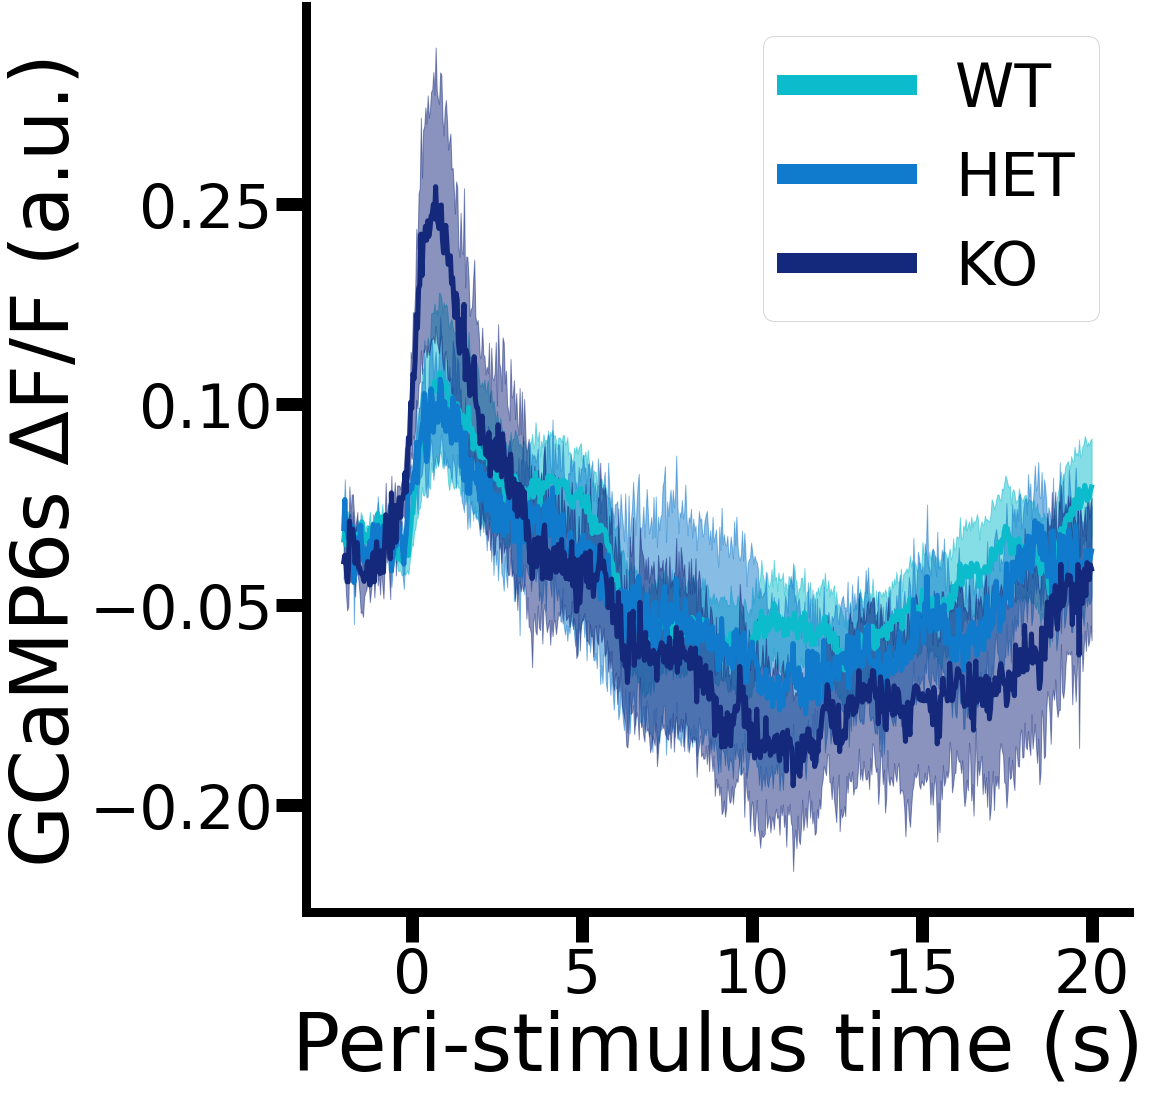

In [ ]:
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():
    #if row['Whisker_responsive']>=0.0:
    #if row['Whisker_responsive']>=0.01: 
        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Whisker_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['WT','HET','KO'], ages=[14,15,16], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)
leg = plt.legend(fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Peri-stimulus time (s)',fontsize=80)
#replace x ticks at time 0,60,120,.. 660 with -2,0,2,.. 20
plt.xticks(np.linspace(0,600,5),np.linspace(0,20,5).astype(int),fontsize=60)
plt.yticks(np.arange(-0.2,0.3,0.15), fontsize=60)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Blue_Whisker_response_22s_p14-16.svg',dpi=300)


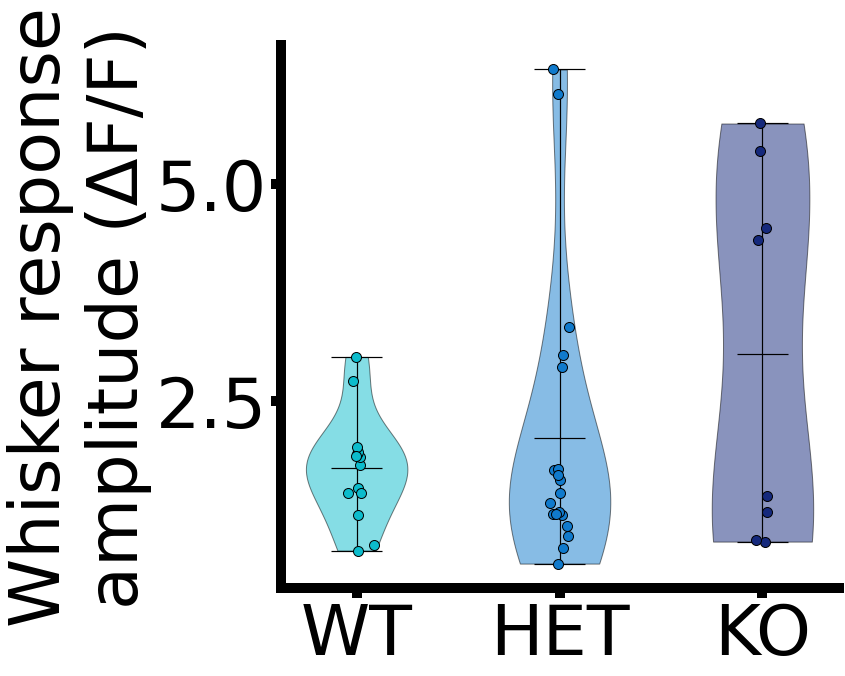

In [602]:
plt.figure(figsize=(10,10))
df_2 = df[df['Whisker_response_max_cropped'].notnull()]
PdA.violin_plot(df_2[(df_2['age']>13)&(df_2['age']<17)],parameter='Whisker_response_max_cropped' , genotypes=['WT','HET','KO'], y_label = 'Whisker response\namplitude (ΔF/F)', color = [color1,color2,color3],title = None, fontsize = 70)
#Savefig
plt.savefig(Save_path + 'Whisker_response_max_violin.svg', dpi=300, bbox_inches='tight',format='svg')

In [308]:
# Testing significance, WT KO different
df_WT_HET_KO = df[(df['genotype']=='WT') | (df['genotype']=='HET') | (df['genotype']=='KO')]
#Replace control for 0 and ssri for     

#select age <11
df_WT_HET_KO = df_WT_HET_KO[(df_WT_HET_KO['age']>13) & (df_WT_HET_KO['age']<17)]

#df_WT_HET_KO = df_WT_HET_KO.groupby(['animal']).mean()

df_WT_HET_KO = df_WT_HET_KO.replace('WT',0)
df_WT_HET_KO = df_WT_HET_KO.replace('HET',1)
df_WT_HET_KO = df_WT_HET_KO.replace('KO',2)
#Remove nans in whisker response AUC
df_WT_HET_KO = df_WT_HET_KO[df_WT_HET_KO['Whisker_response_max_cropped'].notnull()]
# Perform the ANOVA
print(f_oneway(df_WT_HET_KO[df_WT_HET_KO['genotype']==0]['Whisker_response_max_cropped'],df_WT_HET_KO[df_WT_HET_KO['genotype']==1]['Whisker_response_max_cropped'],df_WT_HET_KO[df_WT_HET_KO['genotype']==2]['Whisker_response_max_cropped']))
# Fisher LSD
CaaN.fishers_lsd_from_df(df_WT_HET_KO, 'Whisker_response_max_cropped', 'genotype', alpha=0.05)


F_onewayResult(statistic=3.8583555096793147, pvalue=0.024761435613131905)


[{'group1': 0,
  'group2': 1,
  'mean_diff': -0.21042834021085755,
  't_stat': -0.7361047452599176,
  'ci_lower': -0.7811809938037803,
  'ci_upper': 0.36032431338206516,
  'significant': False,
  'pval': 0.46427520866058225},
 {'group1': 0,
  'group2': 2,
  'mean_diff': -1.260008219026658,
  't_stat': -2.233079394867322,
  'ci_lower': -2.3939048991127994,
  'ci_upper': -0.1261115389405163,
  'significant': True,
  'pval': 0.030143578445430703}]

## Interneurons

### Import interneuron single cell data

In [ ]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_10_23_df_data_interneuron' 
#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)



df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']



Number of rows removed: 54


In [9]:
#Print number of 'Control' and 'WT' animals unique
print('Number of animals of each genotype:')
print('WT: ' + str(len(df[df['genotype'] == 'WT']['animal'].unique())))
#Control
print('Control: ' + str(len(df[df['genotype'] == 'Control']['animal'].unique())))

Number of animals of each genotype:
WT: 19
Control: 12


In [7]:
#Count the number of animals of each genotype with Vip or Nkx2-1 interneurons

print('Number of animals of each genotype with Vip or Nkx2-1 interneurons:')
print('Vip')
print('WT: ' + str(len(df[(df['genotype'] == 'WT') & (df['interneuron'] == 'Vip')]['animal'].unique())))
print('HET: ' + str(len(df[(df['genotype'] == 'HET') & (df['interneuron'] == 'Vip')]['animal'].unique())))
print('KO: ' + str(len(df[(df['genotype'] == 'KO') & (df['interneuron'] == 'Vip')]['animal'].unique())))
print('Nkx2-1')
print('WT: ' + str(len(df[(df['genotype'] == 'WT') & (df['interneuron'] == 'Nkx2.1')]['animal'].unique())))
print('HET: ' + str(len(df[(df['genotype'] == 'HET') & (df['interneuron'] == 'Nkx2.1')]['animal'].unique())))
print('KO: ' + str(len(df[(df['genotype'] == 'KO') & (df['interneuron'] == 'Nkx2.1')]['animal'].unique())))
      

Number of animals of each genotype with Vip or Nkx2-1 interneurons:
Vip
WT: 4
HET: 9
KO: 5
Nkx2-1
WT: 6
HET: 8
KO: 0


### Event analysis

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/240997565.py:9: RuntimeWarning: All-NaN slice encountered
  tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/240997565.py:10: RuntimeWarning: All-NaN slice encountered
  tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)


WT: 201
HET: 1361
KO: 546
ShapiroResult(statistic=0.7777547240257263, pvalue=3.578541619186416e-16)
KruskalResult(statistic=215.1092493758614, pvalue=1.9481392432809572e-47)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   1.0    2.0 -114.7844 0.0868 -241.9756  12.4067  False
   1.0    3.0  280.8181  0.001  141.9478 419.6884   True
   2.0    3.0  395.6025  0.001  310.3331  480.872   True
--------------------------------------------------------


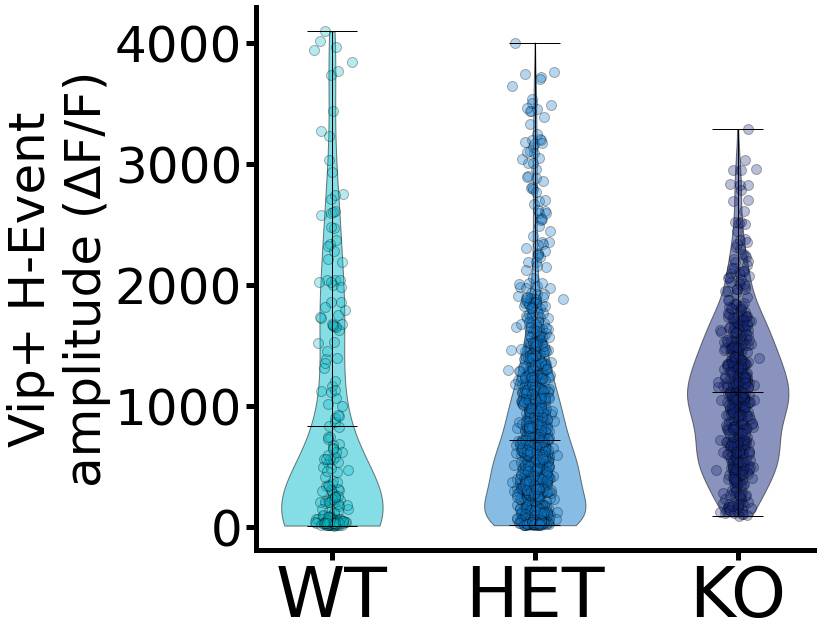

In [ ]:
WT = []
HET = []
KO = []

for age in range(7,11):
    df_a = df[df['age']==age]
    for i,row in df_a[df_a['interneuron']=='Vip'].iterrows():
        try:
            tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)
            tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)
    
            if row['genotype'] == 'WT':
                WT.append(tmp[:,0])#/tmp[:,1])
            if row['genotype'] == 'HET':
                HET.append(tmp[:,0])#/tmp[:,1])
            if row['genotype'] == 'KO':
                KO.append(tmp[:,0])#/tmp[:,1])

        except:
            pass
try:
    WT = (np.hstack(WT)).astype(float)
    HET = (np.hstack(HET)).astype(float)
    KO = (np.hstack(KO)).astype(float)
except:
    pass



#Violin plot of WT,HET,KO
plt.figure(figsize=(10,10))
#Make 0 nans in WT,HET,KO
WT[WT==0] = np.nan
HET[HET==0] = np.nan
KO[KO==0] = np.nan

violin = plt.violinplot([WT[~np.isnan(WT)]],positions=[1],showmeans=True,showextrema=True)
violin2 = plt.violinplot([HET],positions=[2],showmeans=True,showextrema=True)
violin3 = plt.violinplot([KO],positions=[3],showmeans=True,showextrema=True)

#set all edges black
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp = violin2[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp = violin3[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
#color violin plot faces
for pc in violin['bodies']:
    pc.set_facecolor(color1)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
for pc in violin2['bodies']:
    pc.set_facecolor(color2)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
for pc in violin3['bodies']:
    pc.set_facecolor(color3)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

    
#scatter points on top
plt.scatter(np.ones(WT.shape[0])+np.random.normal(1,0.035,WT.shape[0])-1,WT,color=color1,edgecolors='black',s=100, alpha=0.3)
plt.scatter(np.ones(HET.shape[0])+np.random.normal(1,0.035,HET.shape[0]),HET,color=color2,edgecolors='black',s=100, alpha=0.3)
plt.scatter(np.ones(KO.shape[0])+np.random.normal(1,0.035,KO.shape[0])+1,KO,color=color3,edgecolors='black',s=100, alpha=0.3)


#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Set x and y ticks size
plt.xticks(fontsize=70)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xticks([1,2,3],['WT','HET','KO'])
plt.ylabel('Vip+ H-Event\namplitude (ΔF/F)',fontsize=50)

#Make axis thicker
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)

plt.savefig(Save_path + 'VIP_H_event_amplitude.svg',dpi=300,bbox_inches='tight', format='svg')

#Print lengths of each genotype
print('WT: ' + str(WT.shape[0]))
print('HET: ' + str(HET.shape[0]))
print('KO: ' + str(KO.shape[0]))
#Shapiro test
print(stats.shapiro(WT[~np.isnan(WT)]))
#Krustal wallis
print(stats.kruskal(WT[~np.isnan(WT)],HET[~np.isnan(HET)],KO[~np.isnan(KO)]))
#Tukey
print(tukey.MultiComparison(np.hstack((WT[~np.isnan(WT)],HET[~np.isnan(HET)],KO[~np.isnan(KO)])),np.hstack((np.ones(WT[~np.isnan(WT)].shape[0]),np.ones(HET[~np.isnan(HET)].shape[0])+1,np.ones(KO[~np.isnan(KO)].shape[0])+2))).tukeyhsd().summary())




C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/6842034.py:10: RuntimeWarning: All-NaN slice encountered
  tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/6842034.py:9: RuntimeWarning: All-NaN slice encountered
  tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)


WT: 555
HET: 1020
7.696082215338775e-19
MannwhitneyuResult(statistic=311316.5, pvalue=0.0010448568811475647)


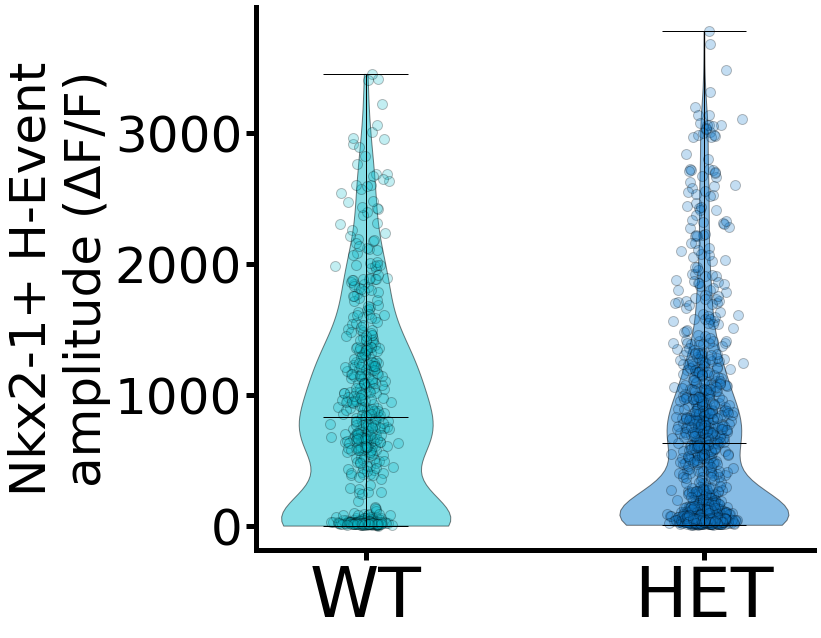

In [518]:
WT = []
HET = []


for age in range(7,11):
    df_a = df[df['age']==age]
    for i,row in df_a[df_a['interneuron']=='Nkx2.1'].iterrows():
        try:
            tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)
            tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)
            if row['genotype'] == 'WT':
                
                WT.append(tmp[:,0])
            if row['genotype'] == 'HET':
                
                HET.append(tmp[:,0])
        except:
            pass

try:
    WT = (np.hstack(WT)).astype(float)
    HET = (np.hstack(HET)).astype(float)  
    #Make 0 nans in WT,HET,KO
    WT[WT==0] = np.nan
    HET[HET==0] = np.nan  
except:
    pass



#Violin plot of WT,HET,KO
plt.figure(figsize=(10,10))




violin = plt.violinplot([WT[~np.isnan(WT)]],positions=[1],showmeans=True,showextrema=True)
violin2 = plt.violinplot([HET],positions=[2],showmeans=True,showextrema=True)


#set all edges black
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp = violin2[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

#color violin plot faces
for pc in violin['bodies']:
    pc.set_facecolor(color1)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

for pc in violin2['bodies']:
    pc.set_facecolor(color2)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)


    
#scatter points on top
plt.scatter(np.ones(WT.shape[0])+np.random.normal(1,0.035,WT.shape[0])-1,WT,color=color1,edgecolors='black',s=100,alpha=0.25)
plt.scatter(np.ones(HET.shape[0])+np.random.normal(1,0.035,HET.shape[0]),HET,color=color2,edgecolors='black',s=100,alpha=0.25)

#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Set x and y ticks size
plt.xticks(fontsize=70)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xticks([1,2],['WT','HET'])
plt.ylabel('Nkx2-1+ H-Event\namplitude (ΔF/F)',fontsize=50)

#Make axis thicker
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)

plt.savefig(Save_path + 'Nkx2-1_H_event_amplitude.svg',dpi=300,bbox_inches='tight', format='svg')

#Print lengths 
print('WT: ' + str(len(WT)))
print('HET: ' + str(len(HET)))

#Shapiro test for normality
_,p = stats.shapiro(WT[~np.isnan(WT)])
print(p)
#Mann whitney u test
print(stats.mannwhitneyu(WT[~np.isnan(WT)],HET[~np.isnan(HET)]))


## Airpuff

### Load data

In [590]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_10_24_df_data_INT'

#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)



df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Proportion_resp')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',n,'Resp' + str((n+1)*10) + '%')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',n,'AResp' + str((n+1)*10) + '%')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Whisker_responsive')
df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',-3,'Airpuff_responsive')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
#df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']



Number of rows removed: 54


### Dissimilarity

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/2689341535.py:8: RuntimeWarning: Mean of empty slice
  df.loc[i,'similarity_mean_airpuff'] = np.nanmean(row['similarity_cd_airpuff'])


SERTKO Age: 7
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   HET     KO   0.0274    0.9 -0.2933  0.348  False
   HET     WT   0.2424 0.1122 -0.0783  0.563  False
    KO     WT    0.215 0.2661 -0.1989 0.6289  False
---------------------------------------------------
SERTKO Age: 8
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   HET     KO  -0.1898 0.2447 -0.4843 0.1047  False
   HET     WT  -0.1064 0.7444 -0.4942 0.2813  False
    KO     WT   0.0834 0.8674 -0.3535 0.5202  False
---------------------------------------------------
SERTKO Age: 9
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   HET     KO  -0.1615 0.1521 -0.3781 0.0551  False
   HET     WT  -0.1354

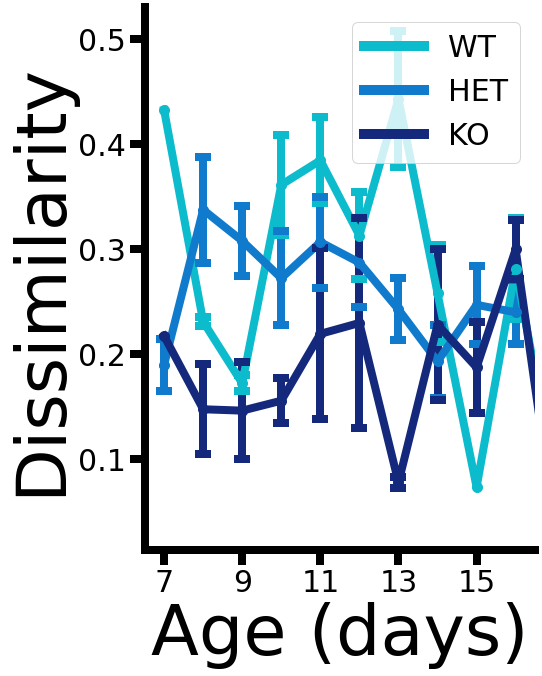

In [591]:
# Load, plot and stats dissimilarity across development, only P13 significant!
df['similarity_mean_airpuff'] = None
#make similarity_cd float
#df['similarity_cd'] = df['similarity_cd'].astype(float)
#mean
for i,row in df.iterrows():
    try:
        df.loc[i,'similarity_mean_airpuff'] = np.nanmean(row['similarity_cd_airpuff'])
    except:
        pass
plt.figure(figsize=(7,10))
PdA.developmental_plot_errorbars(df,'similarity_mean_airpuff',y_label='Similarity', genotype=['WT','HET','KO'],color=[color1,color2,color3])
plt.xlim([-0.5,9.5])
plt.ylabel('Dissimilarity',fontsize=70)
plt.xlabel('Age (days)',fontsize=70)
plt.savefig(Save_path + 'Air_puff_Similarity_across_dev.svg',dpi=300,bbox_inches='tight')


for age in range(7,17):
    print('SERTKO Age: ' + str(age))
    df_tmp = df[df['age']==age]
    #Select only WT, HET and KO
    df_tmp = df_tmp[df_tmp['genotype'].isin(['WT','HET','KO'])]
    #Make float entropy
    df_tmp['similarity_mean_airpuff'] = df_tmp['similarity_mean_airpuff'].astype(float)
    #Remove none and nans on entropy
    df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notnull()]
    #Select only WT, HET, KO
    #df_tmp = df_tmp[df_tmp['genotype']!='Control']
    #df_tmp = df_tmp[df_tmp['genotype']!='SSRI']
    #Run tukey test
    print(tukey.MultiComparison(df_tmp['similarity_mean_airpuff'],df_tmp['genotype']).tukeyhsd().summary())

ShapiroResult(statistic=0.9623261094093323, pvalue=0.8003392219543457)
F_onewayResult(statistic=5.03271152146131, pvalue=0.01696784803352822)
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   -0.064 0.3422 -0.1766  0.0486  False
   0.0    2.0  -0.1592 0.0135 -0.2874 -0.0311   True
   1.0    2.0  -0.0953  0.107 -0.2079  0.0174  False
----------------------------------------------------


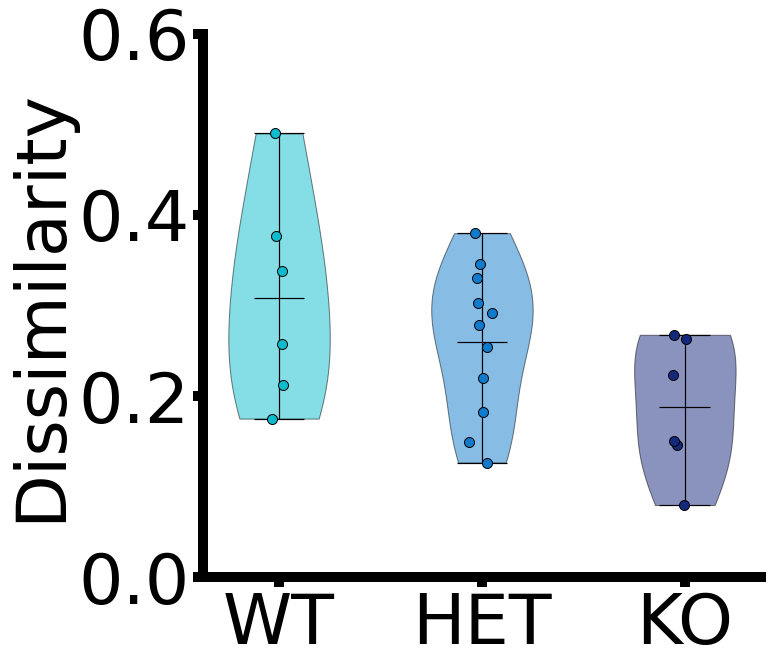

In [592]:
#Mean across developmental window
#Plot
df_tmp = df.copy()
#remove null
plt.figure(figsize=(10,10))
df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notnull()]
PdA.violin_plot(df_tmp,'similarity_mean_airpuff',y_label='Dissimilarity', genotypes=['WT','HET','KO'],color=[color1,color2,color3])
plt.ylim([0,0.6])
plt.savefig(Save_path + 'violin_plot_Air_puff_Dissimilarity.svg',dpi=300,bbox_inches='tight')

#Stats
df_tmp = df[df['age']<17].copy()
#Select only Control, SSRI
df_tmp = df_tmp[df_tmp['genotype']!='Control']
df_tmp = df_tmp[df_tmp['genotype']!='SSRI']
#df_tmp = df_tmp[df_tmp['genotype']!='KO']
#Replace genotype by 0,1,2
df_tmp['genotype'] = df_tmp['genotype'].replace('WT',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('HET',1)
df_tmp['genotype'] = df_tmp['genotype'].replace('KO',2)
#Make entropy float
df_tmp['similarity_mean_airpuff'] = df_tmp['similarity_mean_airpuff'].astype(float)
#Group by animal
df_tmp = df_tmp.groupby(['animal']).mean()
#Remove nans
df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notnull()]
print(stats.shapiro(df_tmp[df_tmp['genotype']==1]['similarity_mean_airpuff']))
#One way ANOVA
print(stats.f_oneway(df_tmp[df_tmp['genotype']==0]['similarity_mean_airpuff'],df_tmp[df_tmp['genotype']==1]['similarity_mean_airpuff'],df_tmp[df_tmp['genotype']==2]['similarity_mean_airpuff']))
#tukey test
print(tukey.MultiComparison(df_tmp['similarity_mean_airpuff'],df_tmp['genotype']).tukeyhsd().summary())



## Supplementary

### Supplemental figure 1

#### Cummulative sum

At P7-10, KS test between WT and HET: KstestResult(statistic=0.0335287548855388, pvalue=0.00025396958333900876)
At P7-10, KS test between WT and KO: KstestResult(statistic=0.04149013039051466, pvalue=0.0007079443863665658)
At P7-10, KS test between HET and KO: KstestResult(statistic=0.052839360199691265, pvalue=2.1186664156402912e-06)
At P11-14, KS test between WT and HET: KstestResult(statistic=0.13246231155778895, pvalue=3.462499060927474e-64)
At P11-14, KS test between WT and KO: KstestResult(statistic=0.13572305974316023, pvalue=1.2436977219568441e-47)
At P11-14, KS test between HET and KO: KstestResult(statistic=0.1707537688442211, pvalue=2.220446049250313e-16)
At P15-16, KS test between WT and HET: KstestResult(statistic=0.08727760423740323, pvalue=1.5543122344752192e-15)
At P15-16, KS test between WT and KO: KstestResult(statistic=0.13422768604929408, pvalue=2.220446049250313e-15)
At P15-16, KS test between HET and KO: KstestResult(statistic=0.10460927546354681, pvalue=7.4181953

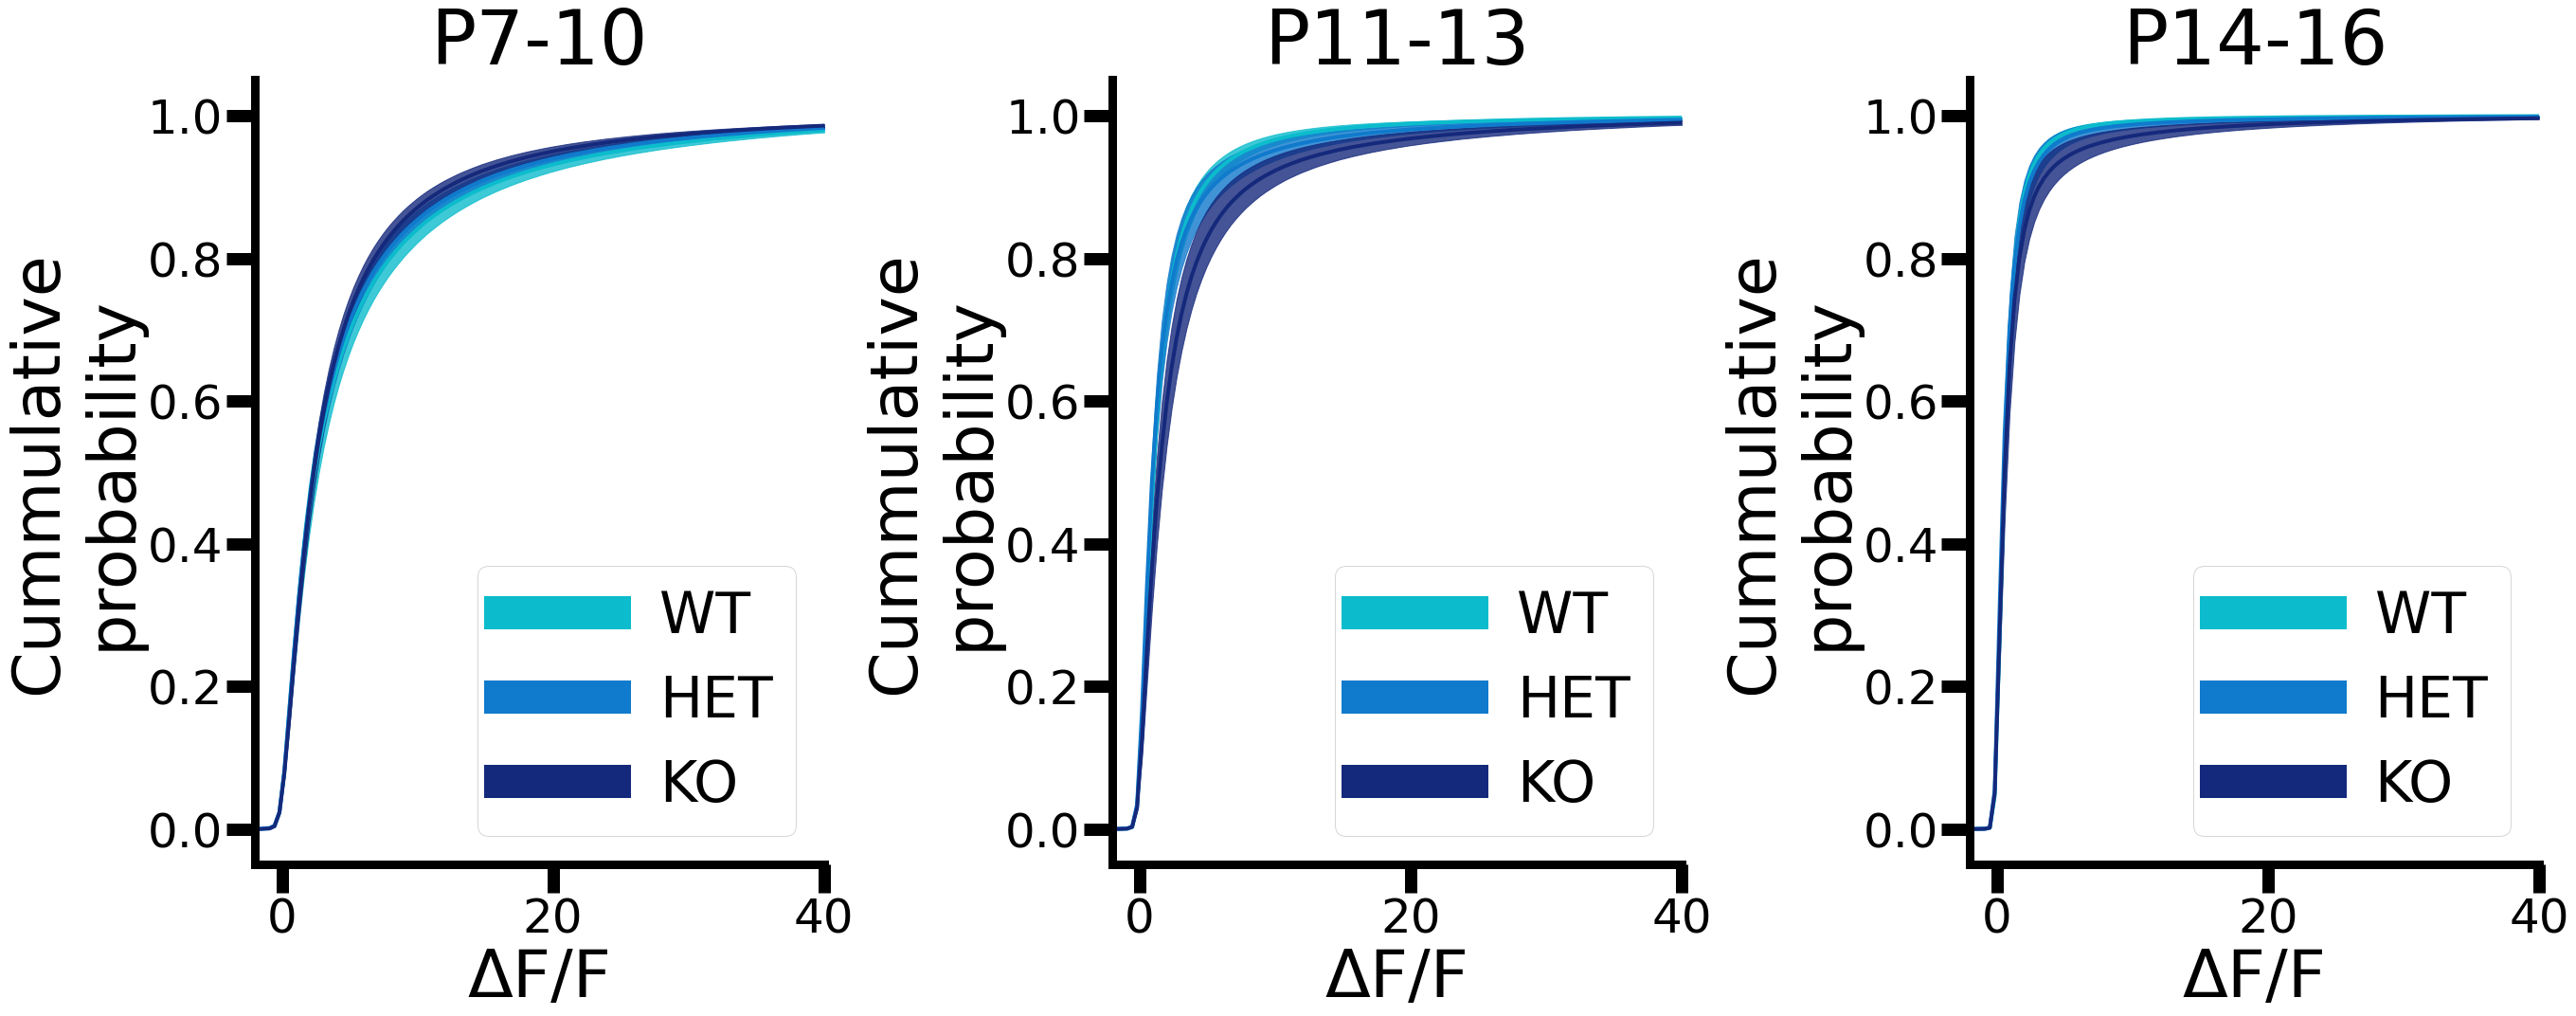

In [533]:
# dF/F Cumulative probability plot
plt.figure(figsize=(50,15))
PdA.cum_sum(df, 'cumulative_1_percentile_dF_F', genotypes=['WT','HET','KO'],color=[color1,color2,color3],ages=[7,8,9,10],sp_number=1,x_lim=40,title='P7-10',vertical_line=False, vertical_line_val=2)
PdA.cum_sum(df, 'cumulative_1_percentile_dF_F', genotypes=['WT','HET','KO'],color=[color1,color2,color3],ages=[11,12,13],sp_number=2,x_lim=40,title='P11-13',vertical_line=False, vertical_line_val=2)
PdA.cum_sum(df, 'cumulative_1_percentile_dF_F', genotypes=['WT','HET','KO'],color=[color1,color2,color3],ages=[14,15,16],sp_number=3,x_lim=40,title='P14-16',vertical_line=False, vertical_line_val=2)

#Run kolmogorov-smirnov test between genotypes
df_7_10 = df[(df['age'] <10)]
#Store all cummulative_1_percentile_dF_F values in a different array for each genotype
WT_7_10 = np.vstack(df_7_10[df_7_10['genotype'] == 'WT']['cumulative_1_percentile_dF_F'])#.values
HET_7_10 = np.vstack(df_7_10[df_7_10['genotype'] == 'HET']['cumulative_1_percentile_dF_F'])#.values
KO_7_10 = np.vstack(df_7_10[df_7_10['genotype'] == 'KO']['cumulative_1_percentile_dF_F'])#.values
#Run KS test
print('At P7-10, KS test between WT and HET: ' + str(stats.ks_2samp(np.reshape(WT_7_10,(WT_7_10.size)),np.reshape(HET_7_10,(HET_7_10.size)))))
print('At P7-10, KS test between WT and KO: ' + str(stats.ks_2samp(np.reshape(WT_7_10,(WT_7_10.size)),np.reshape(KO_7_10,(KO_7_10.size)))))
print('At P7-10, KS test between HET and KO: ' + str(stats.ks_2samp(np.reshape(HET_7_10,(HET_7_10.size)),np.reshape(KO_7_10,(KO_7_10.size)))))

df_11_14 = df[(df['age'] >= 11) & (df['age'] <14)] 
#Store all cummulative_1_percentile_dF_F values in a different array for each genotype
WT_11_14 = np.vstack(df_11_14[df_11_14['genotype'] == 'WT']['cumulative_1_percentile_dF_F'])#.values
HET_11_14 = np.vstack(df_11_14[df_11_14['genotype'] == 'HET']['cumulative_1_percentile_dF_F'])#.values
KO_11_14 = np.vstack(df_11_14[df_11_14['genotype'] == 'KO']['cumulative_1_percentile_dF_F'])#.values
#Run KS test
print('At P11-14, KS test between WT and HET: ' + str(stats.ks_2samp(np.reshape(WT_11_14,(WT_11_14.size)),np.reshape(HET_11_14,(HET_11_14.size)))))
print('At P11-14, KS test between WT and KO: ' + str(stats.ks_2samp(np.reshape(WT_11_14,(WT_11_14.size)),np.reshape(KO_11_14,(KO_11_14.size)))))
print('At P11-14, KS test between HET and KO: ' + str(stats.ks_2samp(np.reshape(HET_11_14,(HET_11_14.size)),np.reshape(KO_11_14,(KO_11_14.size)))))

df_15_16 = df[(df['age'] >= 15)]
#Store all cummulative_1_percentile_dF_F values in a different array for each genotype
WT_15_16 = np.vstack(df_15_16[df_15_16['genotype'] == 'WT']['cumulative_1_percentile_dF_F'])#.values
HET_15_16 = np.vstack(df_15_16[df_15_16['genotype'] == 'HET']['cumulative_1_percentile_dF_F'])#.values
KO_15_16 = np.vstack(df_15_16[df_15_16['genotype'] == 'KO']['cumulative_1_percentile_dF_F'])#.values
#Run KS test
print('At P15-16, KS test between WT and HET: ' + str(stats.ks_2samp(np.reshape(WT_15_16,(WT_15_16.size)),np.reshape(HET_15_16,(HET_15_16.size)))))
print('At P15-16, KS test between WT and KO: ' + str(stats.ks_2samp(np.reshape(WT_15_16,(WT_15_16.size)),np.reshape(KO_15_16,(KO_15_16.size)))))
print('At P15-16, KS test between HET and KO: ' + str(stats.ks_2samp(np.reshape(HET_15_16,(HET_15_16.size)),np.reshape(KO_15_16,(KO_15_16.size)))))


plt.savefig(Save_path + 'SERTKO_Cumulative_1_percentile_dF_F.png', dpi=300, bbox_inches='tight')
plt.savefig(Save_path + 'SERTKO_Cumulative_1_percentile_dF_F.svg', dpi=300, bbox_inches='tight')

#### Entropy

SERTKO Age: 7
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control    HET  -0.8578 0.8917 -3.5885  1.873  False
Control     KO   0.1127    0.9 -3.9377 4.1631  False
Control   SSRI  -0.9059    0.9 -3.8581 2.0464  False
Control     WT  -0.1854    0.9 -2.9162 2.5454  False
    HET     KO   0.9705    0.9 -2.9868 4.9278  False
    HET   SSRI  -0.0481    0.9 -2.8712  2.775  False
    HET     WT   0.6723    0.9 -1.9183  3.263  False
     KO   SSRI  -1.0186    0.9 -5.1318 3.0946  False
     KO     WT  -0.2982    0.9 -4.2554 3.6591  False
   SSRI     WT   0.7204    0.9 -2.1027 3.5435  False
----------------------------------------------------
SERTKO Age: 8
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Control    HET  -0.1296    0.9 -1.5671  1.3078  False
Control     KO

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111464/2432091972.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['Entropy'] = df_tmp['Entropy'].astype(float)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control    HET   2.1453  0.422 -1.3269 5.6175  False
Control     KO   1.9404  0.655  -2.168 6.0488  False
Control   SSRI   2.7939  0.298 -1.2113 6.7992  False
Control     WT   1.2371 0.8815 -2.5376 5.0119  False
    HET     KO  -0.2049    0.9 -3.8915 3.4817  False
    HET   SSRI   0.6486    0.9 -2.9227 4.2199  False
    HET     WT  -0.9082    0.9 -4.2188 2.4025  False
     KO   SSRI   0.8535    0.9 -3.3389  5.046  False
     KO     WT  -0.7032    0.9  -4.676 3.2695  False
   SSRI     WT  -1.5568 0.7641 -5.4228 2.3092  False
----------------------------------------------------
SERTKO Age: 12
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control    HET   0.8853    0.9 -2.9692 4.7397  False
Control     KO    1.249    0.9 

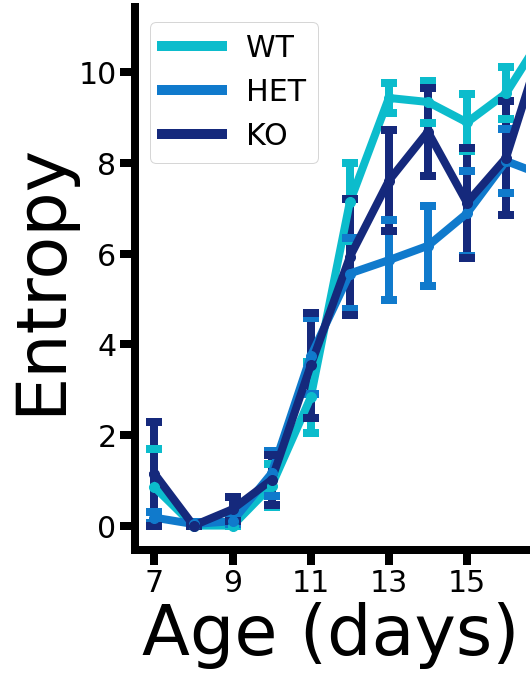

In [552]:
plt.figure(figsize=(7,10))

PdA.developmental_plot_errorbars(df,'Entropy',y_label='Entropy', genotype=['WT','HET','KO'],color=[color1,color2,color3])
plt.xlim([-0.5,9.5])
plt.ylabel('Entropy',fontsize=70)
plt.xlabel('Age (days)',fontsize=70)
plt.savefig(Save_path + 'Entropy_across_dev.svg',dpi=300,bbox_inches='tight')

#Run stats
#stating(df,'Entropy',genotypes=['WT','HET','KO']) (0.0, 0.823, 0.016)
for age in range(7,17):
    print('SERTKO Age: ' + str(age))
    df_tmp = df[df['age']==age]
    #Make float entropy
    df_tmp['Entropy'] = df_tmp['Entropy'].astype(float)
    #Remove none and nans on entropy
    df_tmp = df_tmp[df_tmp['Entropy'].notnull()]
    #Select only WT, HET, KO
    #df_tmp = df_tmp[df_tmp['genotype']!='Control']
    #df_tmp = df_tmp[df_tmp['genotype']!='SSRI']
    #Run tukey test
    print(tukey.MultiComparison(df_tmp['Entropy'],df_tmp['genotype']).tukeyhsd().summary())
    

KruskalResult(statistic=0.2740236118664666, pvalue=0.8719599317706057)


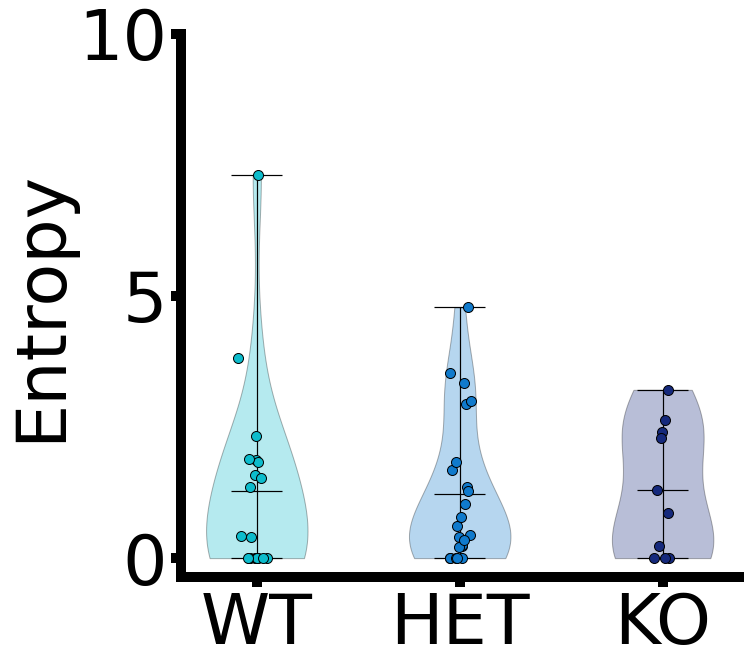

In [555]:
#Plot violin plot of average entropy between p7-10
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<12],'Entropy',y_label='Entropy', genotypes=['WT','HET','KO'],color=[color1,color2,color3])
plt.yticks([0,5,10 ],fontsize=70)
plt.savefig(Save_path + 'Entropy_p7-12.svg',dpi=300,bbox_inches='tight')
#Run stats on mean 
df_tmp = df[df['age']<12]
#Select only WT, HET, KO
df_tmp = df_tmp[df_tmp['genotype']!='Control']
df_tmp = df_tmp[df_tmp['genotype']!='SSRI']
#Replace genotype by 0,1,2
df_tmp['genotype'] = df_tmp['genotype'].replace('WT',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('HET',1)
df_tmp['genotype'] = df_tmp['genotype'].replace('KO',2)
#Make entropy float
df_tmp['Entropy'] = df_tmp['Entropy'].astype(float)
#Group by animal
df_tmp = df_tmp.groupby(['animal']).mean()
#One way anova
#print(scipy.stats.f_oneway(df_tmp[df_tmp['genotype']==0]['Entropy'],df_tmp[df_tmp['genotype']==1]['Entropy'],df_tmp[df_tmp['genotype']==2]['Entropy']))
#Krusskal wallis
print(stats.kruskal(df_tmp[df_tmp['genotype']==0]['Entropy'],df_tmp[df_tmp['genotype']==1]['Entropy'],df_tmp[df_tmp['genotype']==2]['Entropy']))




### Correlation distance

In [562]:
#To account for correlations in the edge introducing noise, crop
#Make new colomn with cropped traces
df['Correlations_distance_cropped'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Correlations_distance_cropped'] = np.array(row['Correlations_distance'][:10])
    except:
        pass

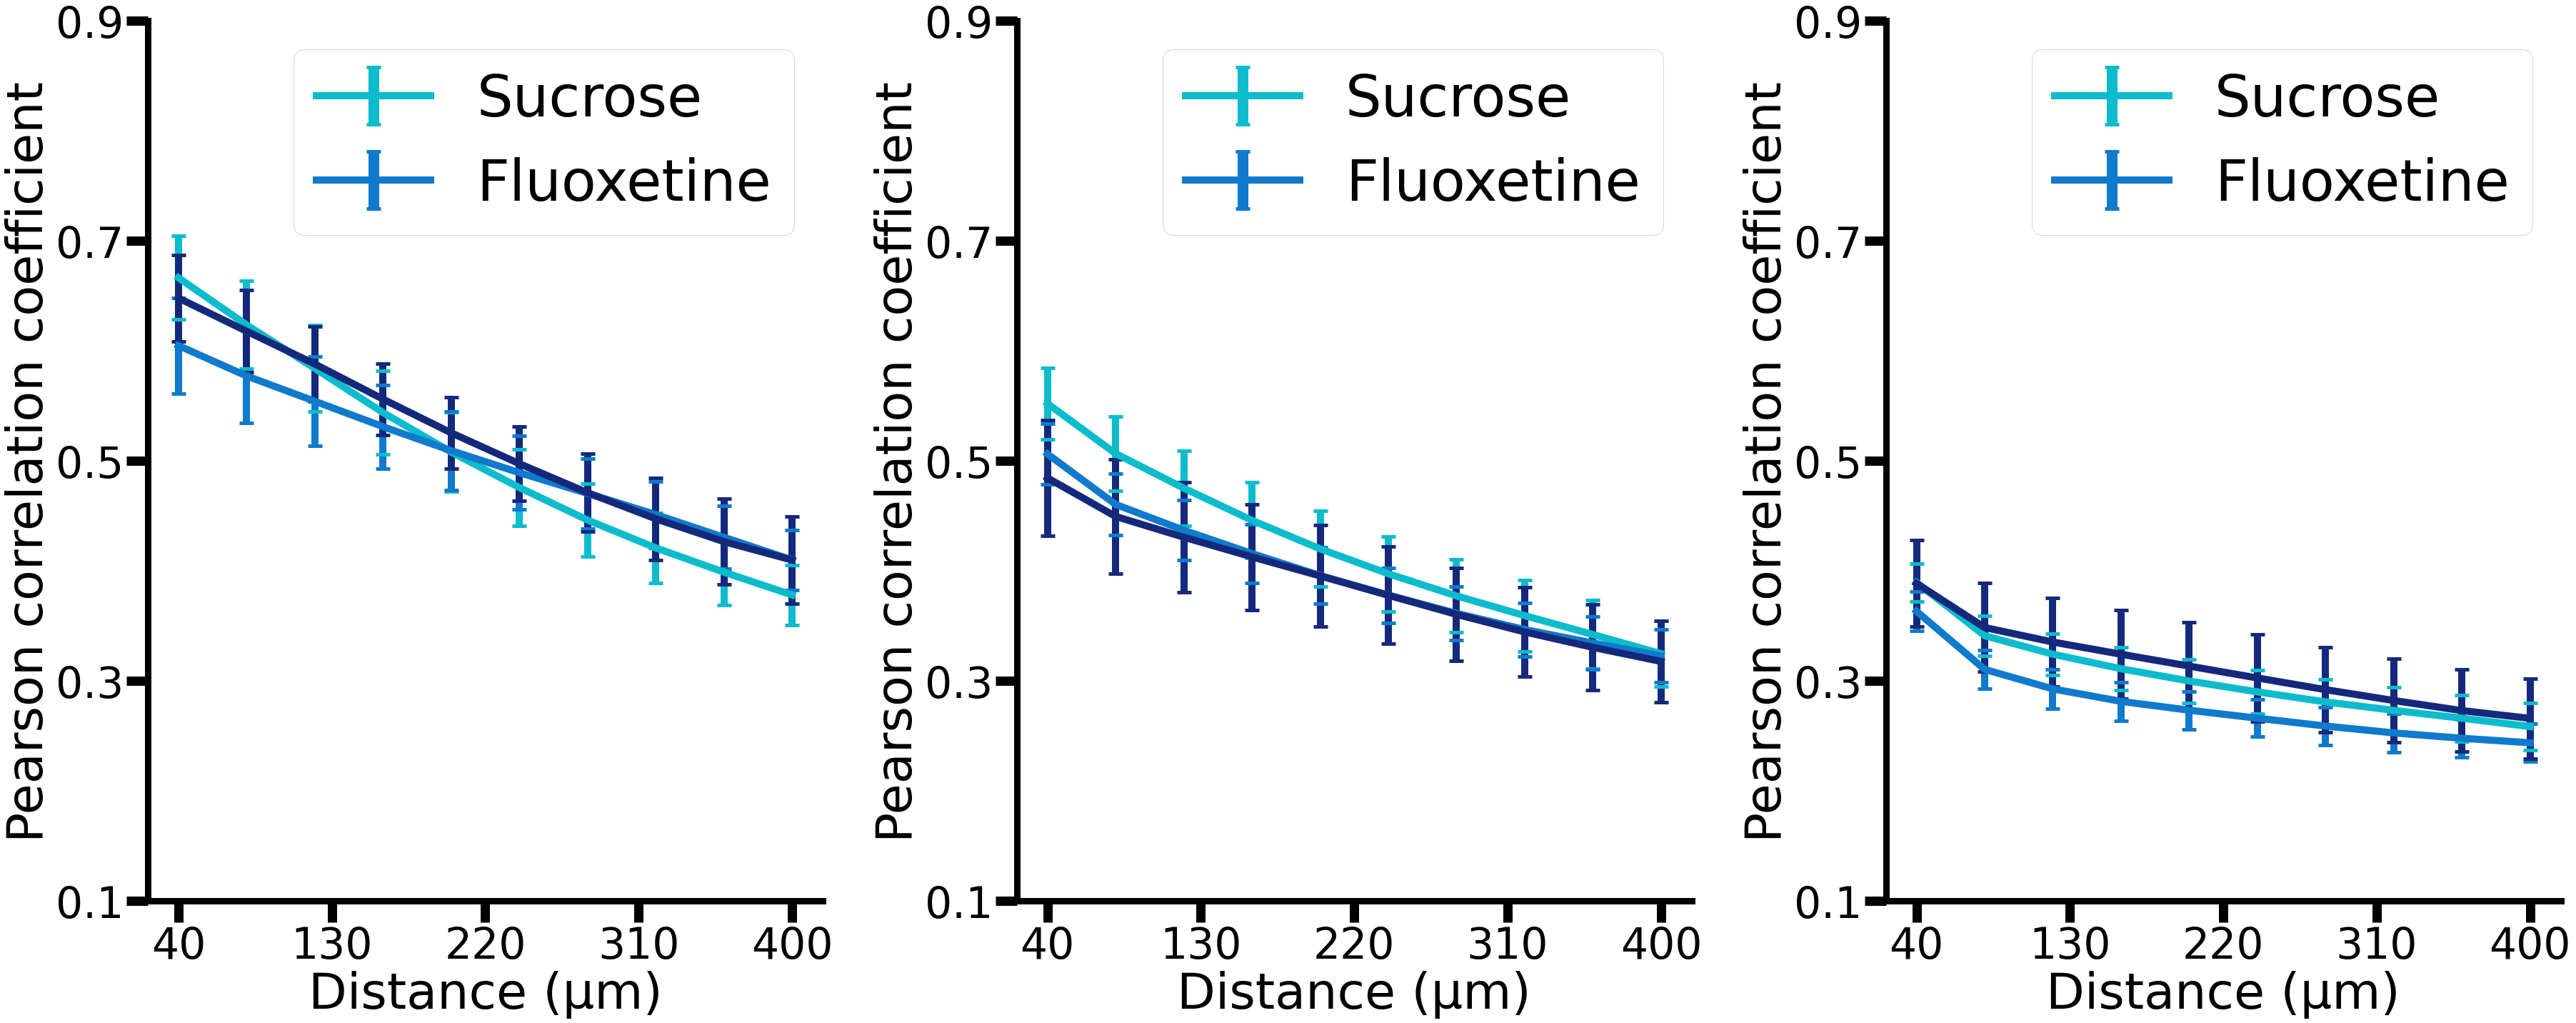

In [563]:
plt.figure(figsize=(50,20))
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['WT','HET','KO'], ages=[7,8,9,10], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=3,sp_number=1)
plt.ylim([0.1,0.85])
leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=80)
for leg in leg.legendHandles:
    leg.set_linewidth(15.0)
#Set xticks from 0 to 10 as 40 to 400
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=60)
plt.yticks(np.arange(0.1,1,0.2),fontsize=60)
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['WT','HET','KO'], ages=[11,12,13], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=3,sp_number=2)
plt.ylim([0.1,0.85])
leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=80)
for leg in leg.legendHandles:
    leg.set_linewidth(15.0)
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=60)
plt.yticks(np.arange(0.1,1,0.2),fontsize=60)
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['WT','HET','KO'],ages=[14,15,16], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=3,sp_number=3)
plt.ylim([0.1,0.85])
leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=80)
for leg in leg.legendHandles:
    leg.set_linewidth(15.0)
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=60)
plt.yticks(np.arange(0.1,1,0.2),fontsize=60)
#PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['Control','WT','HET','KO','SSRI'], ages=np.linspace(20,30,11).astype(int), color = ['dimgrey','k','c','m','orange'],title = None,sp_row=1,sp_colomn=4,sp_number=4)
plt.savefig(Save_path + 'Correlations_distance.svg',bbox_inches='tight',dpi=300)

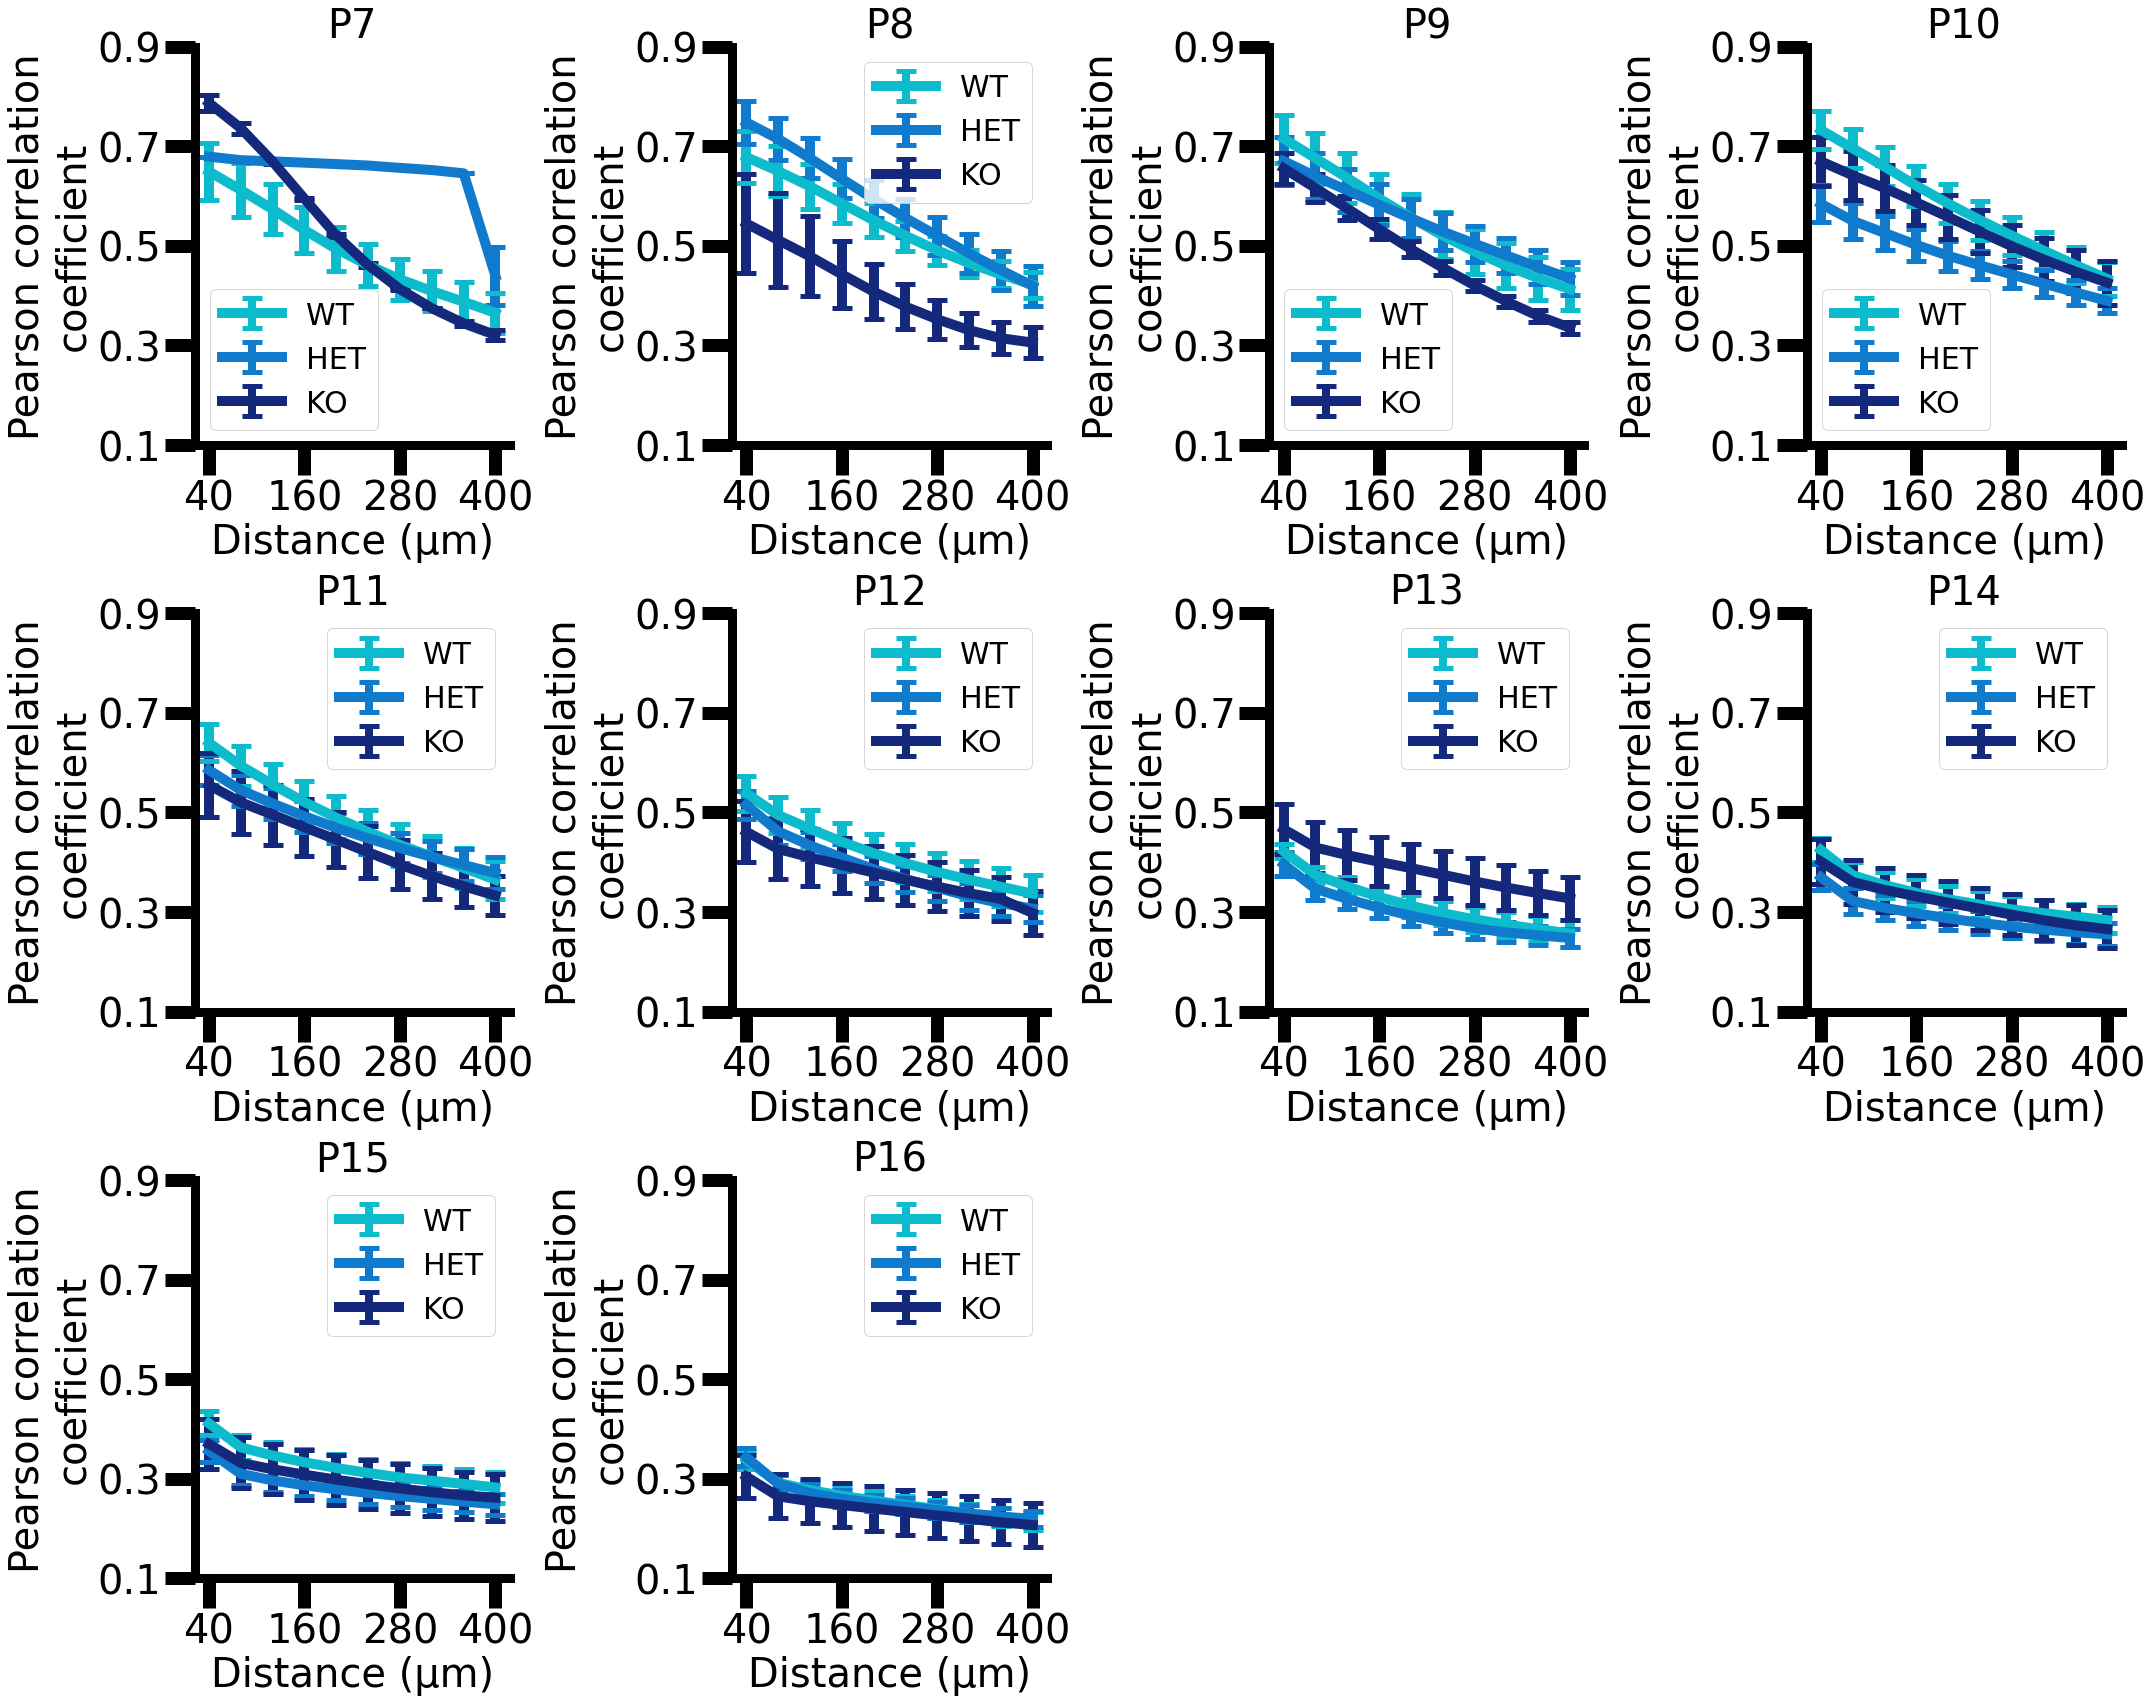

In [583]:

plt.figure(figsize=(30,30))
for i in range(7,17):
    plt.subplot(4,4,i-6)
    PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['WT','HET','KO'], ages=[i], color = [color1,color2,color3],title = None,sp_row=4,sp_colomn=4,sp_number=i-6)
    plt.ylim([0.1,0.85])
    leg = plt.legend(['WT','HET','KO',],fontsize=30)
    for leg in leg.legendHandles:
        leg.set_linewidth(8.0)
    #Set xticks from 0 to 10 as 40 to 400
    plt.xticks(np.linspace(0,9,4),np.linspace(40,400,4).astype(int),fontsize=40)
    plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
    plt.ylabel('Pearson correlation\ncoefficient', fontsize=40)
    plt.title('P' + str(i),fontsize=40)
    plt.xlabel('Distance (μm)',fontsize=40)
    plt.tight_layout()
    
    #Savefig
    plt.savefig(Save_path + 'ALL_Correlations_distance_with_SERTKO.svg',bbox_inches='tight',dpi=300)

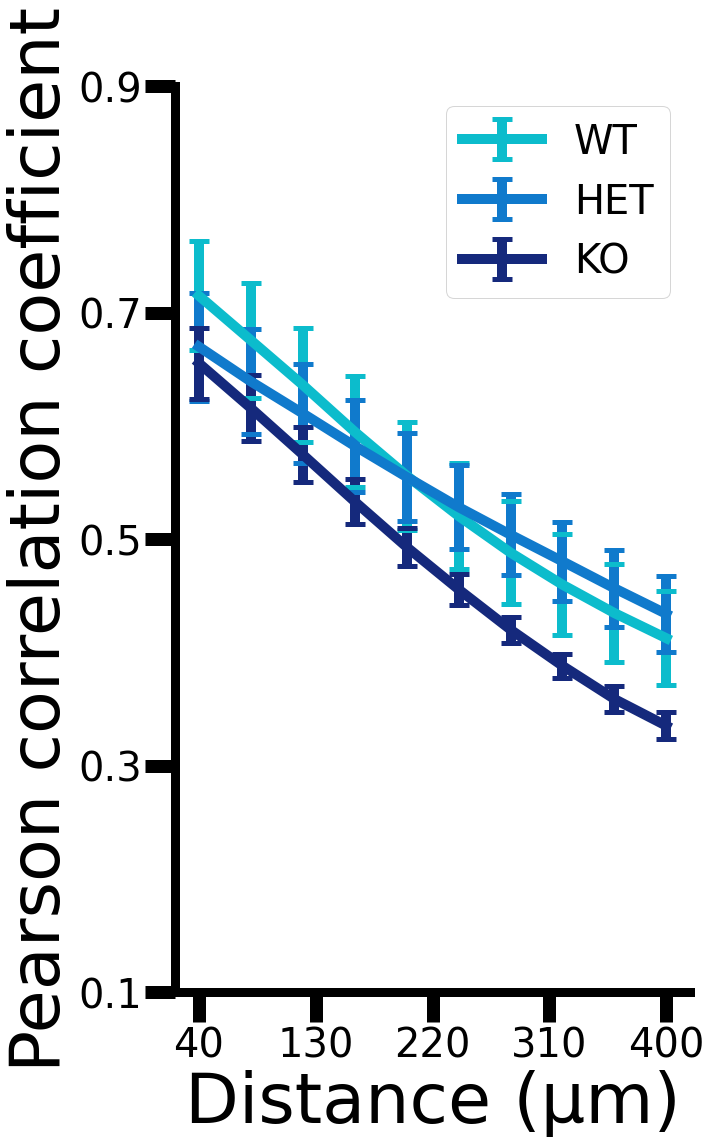

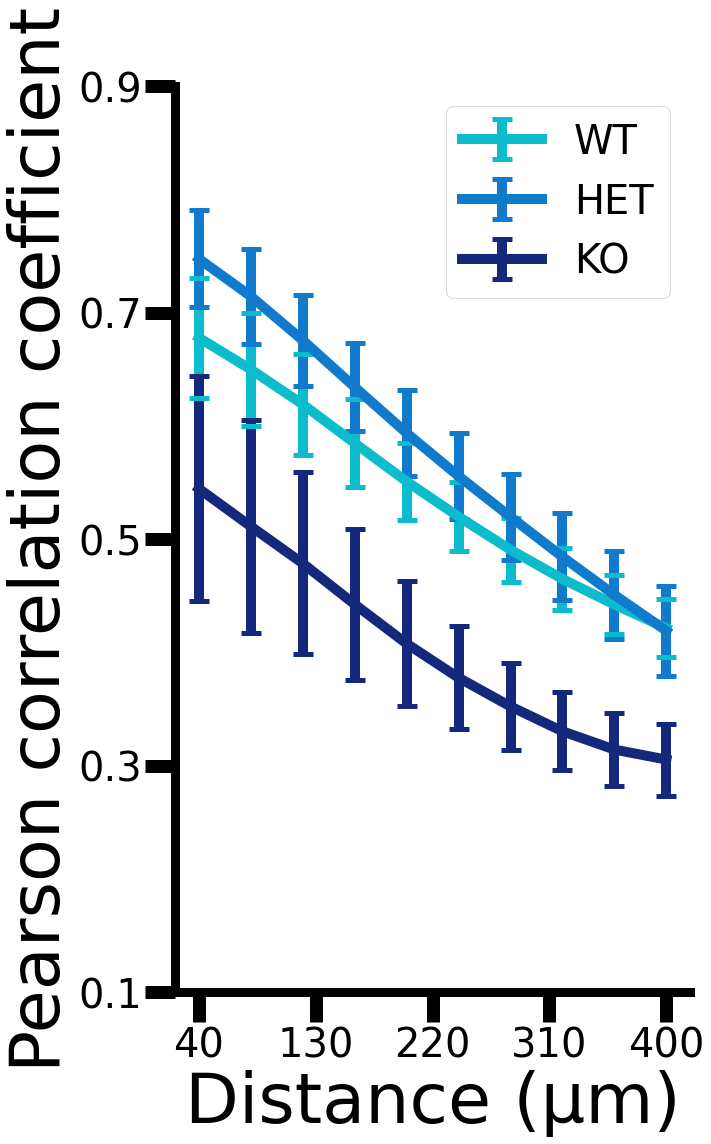

In [584]:
plt.figure(figsize=(10,15))
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['WT','HET','KO'], ages=[9], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1)
plt.ylim([0.1,0.85])
leg = plt.legend(['WT','HET','KO','Sucrose','Fluoxetine'],fontsize=40)
for leg in leg.legendHandles:
    leg.set_linewidth(10.0)
#Set xticks from 0 to 10 as 40 to 400
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=40)
plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
#Savefig
plt.savefig(Save_path + 'P9_Correlations_distance_with_SERTKO.svg',bbox_inches='tight',dpi=300)
plt.figure(figsize=(10,15))
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['WT','HET','KO'], ages=[8], color = [color1,color2,color3],title = None,sp_row=1,sp_colomn=1,sp_number=1)
plt.ylim([0.1,0.85])
leg = plt.legend(['WT','HET','KO','Sucrose','Fluoxetine'],fontsize=40)
for leg in leg.legendHandles:
    leg.set_linewidth(10.0)
#Set xticks from 0 to 10 as 40 to 400
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=40)
plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
#Savefig
plt.savefig(Save_path + 'P8_Correlations_distance_with_SERTKO.svg',bbox_inches='tight',dpi=300)

In [565]:
# Significant difference in 7, 8, 10, 13, 14, 15
for age in range(7,17):
    df_a = df[df['age'] == age]
    #Genotypes WT, HET, KO
    df_a = df_a[df_a['genotype'].isin(['WT','HET','KO'])]
    #remove nans
    df_a = df_a[df_a['Correlations_distance_cropped'].notnull()]
    #extract each value in correlation_distance_cropped to a new row with another column named distance that indicates the index of the value, without my own functions
    df_a = df_a.reset_index(drop=True)


    # Melt the dataframe
    df_melted = df_a.explode('Correlations_distance_cropped').reset_index(drop=True)
    df_melted['age'] = np.tile(np.arange(1, 11), len(df_a))
    df_melted.rename(columns={'Correlations_distance_cropped': 'correlation_value'}, inplace=True)
    #Conver to float
    df_melted['correlation_value'] = df_melted['correlation_value'].astype(float)
    print('--------------- Age: ' + str(age) + ' -----------------')
    CaaN.stating(df_melted,'correlation_value',['WT','HET','KO'])

    #drop empty and nasn
    df_melted = df_melted[df_melted['correlation_value'].notnull()]
    df_melted = df_melted[df_melted['correlation_value'] != 'None']

    #for dist in range(1,11):
        #print('Age: ' + str(age) + ' Distance: ' + str(dist))
        #run tukey test
        #print('Tukey HSD test results:')
        
       # print(tukey.pairwise_tukeyhsd(endog = df_melted[df_melted['age']==dist]['correlation_value'], groups= df_melted[df_melted['age']==dist]['genotype'],alpha=0.05))

        #t test
        #print('T-test results:')
        #print(stats.ttest_ind(df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='WT'],df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='HET']))
        #print(stats.ttest_ind(df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='WT'],df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='KO']))
        #print(stats.ttest_ind(df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='HET'],df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='KO']))


--------------- Age: 7 -----------------
Two way ANOVA results:
                      sum_sq    df         F    PR(>F)
C(age)              0.958983   9.0  4.791980  0.000077
C(genotype)         0.194976   2.0  4.384285  0.016632
C(age):C(genotype)  0.141746  18.0  0.354147  0.991465
Residual            1.356385  61.0       NaN       NaN
Shapiro p-val:1.0
--------------- Age: 8 -----------------
Two way ANOVA results:
                      sum_sq     df          F        PR(>F)
C(age)              1.900054    9.0   7.868869  7.634584e-10
C(genotype)         0.843070    2.0  15.711675  4.845823e-07
C(age):C(genotype)  0.033306   18.0   0.068966  1.000000e+00
Residual            5.097587  190.0        NaN           NaN
Shapiro p-val:1.0
--------------- Age: 9 -----------------
Two way ANOVA results:
                      sum_sq     df         F        PR(>F)
C(age)              1.901520    9.0  7.842267  5.124317e-10
C(genotype)         0.110051    2.0  2.042425  1.321662e-01
C(age):C(gen

### Raw signal control

In [ ]:
df = PdA.extract_to_separate_coloumn(df, 'Raw_stats',0,'Mean')

Two way ANOVA results:
                          sum_sq     df          F        PR(>F)
C(age)              9.611282e+06   18.0  12.050348  1.253787e-07
C(genotype)         9.331247e+04    4.0   0.526466  4.684351e-01
C(age):C(genotype)  1.231217e+07   72.0   3.859161  2.584438e-15
Residual            2.219969e+07  501.0        NaN           NaN
Shapiro p-val:3.373306973234669e-26


c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 72, but rank is 51
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 3
  warnings.warn('covariance of constraints d

Permutation test results:
(0.0, 0.491, 0.0)


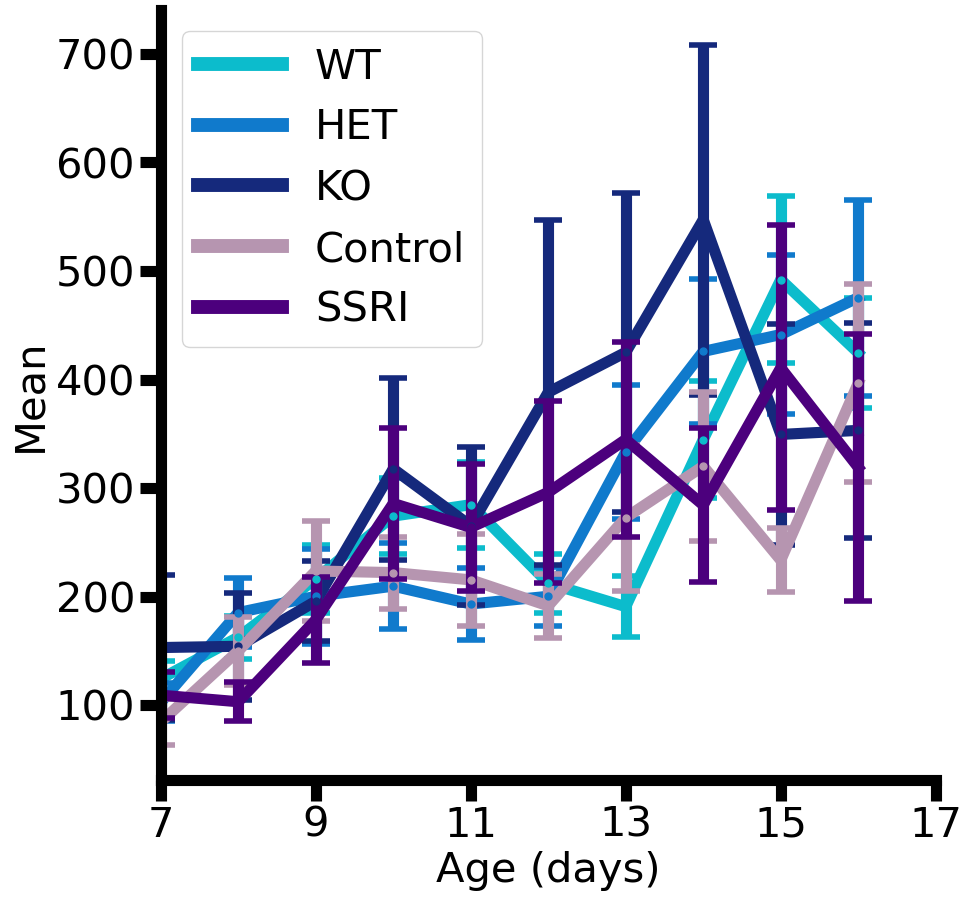

In [18]:
#Plot mean acros development for each genotype
plt.figure(figsize=(10,10))
PdA.developmental_plot_errorbars(df[df['age']<17],'Mean',y_label='Mean', genotype=['WT','HET','KO','Control','SSRI'],color=[color1,color2,color3,color4,color5])
CaaN.stating(df,'Mean',['WT','HET','KO','Control','SSRI'])

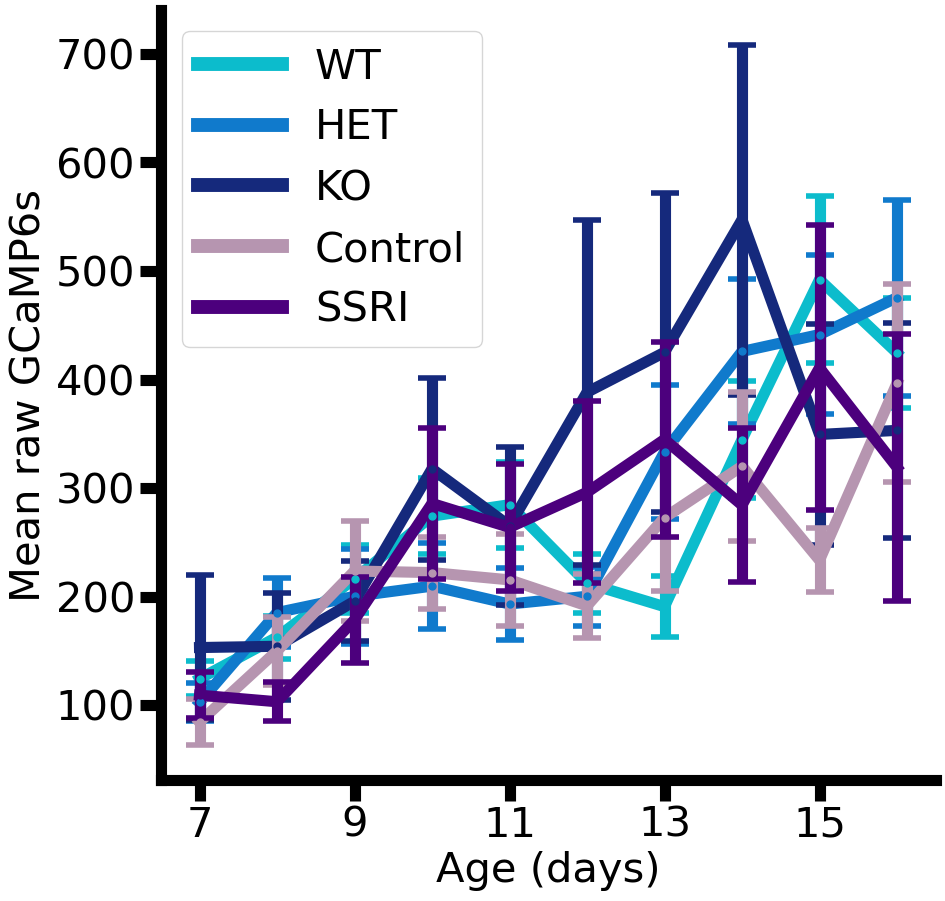

In [23]:
#Plot mean acros development for each genotype
plt.figure(figsize=(10,10))
PdA.developmental_plot_errorbars(df[df['age']<17],'Mean',y_label='Mean raw GCaMP6s', genotype=['WT','HET','KO','Control','SSRI'],color=[color1,color2,color3,color4,color5])
plt.xlim([-0.5,9.5])
#save fig
Save_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Paper_figures/Rebuttals/' 
plt.savefig(Save_path + 'Mean_across_development_per_genotype.svg',dpi=300,bbox_inches='tight')
#CaaN.stating(df,'Mean',['WT','HET','KO','Control','SSRI'])